# LCP Project: analysis of MAGIC04 dataset
First, we import the libraries

In [1]:
# math libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
import seaborn as sns
import random as rnd

# general OS libraries
from time import time
import gzip
import os
import operator
import warnings
from IPython.core.interactiveshell import InteractiveShell

# ML libraries
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.datasets import make_classification
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Then, we import the dataset and we put it into a DataFrame:

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data.7"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']
data   
#### save data in a DataFrame

--2025-03-09 11:25:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘magic04.data.54’

magic04.data.54         [             <=>    ]   1.41M   480KB/s    in 3.0s    

2025-03-09 11:25:09 (480 KB/s) - ‘magic04.data.54’ saved [1477391]



,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,category
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In this cell we print the number of data of each type and the relative frequence

In [3]:
print('All data points:',len(data['fAlpha']),'points for',len(data.columns[:]),'columns')
print('labels and their relative frequencies:')

ngamma = len(data[data['category'] == 'g'] )
nback = len(data[data['category'] == 'h'] )
print(f'signal: {ngamma} \t {round(ngamma/len(data['fAlpha'])*100,2)}%')
print(f'signal: {nback} \t {round(nback/len(data['fAlpha'])*100,2)}%')



All data points: 19019 points for 11 columns
labels and their relative frequencies:
signal: 12331 	 64.84%
signal: 6688 	 35.16%


Here we write some useful functions for the code

## ML functions

In [4]:
# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function takes the point that has the lowest distance from FPR=0 and TPR=1 and computes Q for that point values
def get_best_Q(fpr,tpr):
    distances = np.zeros(len(fpr))
    
    for i in range(len(fpr)):
        distances[i] = np.sqrt(fpr[i]**2+(1-tpr[i])**2)
        
    min_dist_idx = np.argmin(distances)
    
    best_Q = tpr[min_dist_idx] / np.sqrt(fpr[min_dist_idx])
    return best_Q

## Other functions
### Cutting functions

In [5]:
# this function finds cut value starting from possible max
def find_max_cut_value(X_train,Y_train,sel_label,min_hadrons):
    new_X = X_train[X_train.columns[sel_label]]
    new_data = np.vstack((new_X,Y_train))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    
    #new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    
    # setup vars, cut value is  set to max of the label, so that in worst scenario all points are true hadrons
    true_hadrons = 0
    max_cut_value = new_data_sorted[0,0]
    
    for i in range(new_data_sorted.shape[1]):
        if new_data_sorted[1,i] == -1:
            true_hadrons += 1
        if true_hadrons == min_hadrons:
            max_cut_value = new_data_sorted[0,i]
            
    return max_cut_value

# this functions returns the number of true positive and false positive points on test set
def find_tp_fp(X_test,Y_test,sel_label,cut_value):
    new_X = X_test[X_test.columns[sel_label]]
    new_data = np.vstack((new_X,Y_test))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    fp = 0
    tp = 0
    
    for i in range(new_data_sorted_reversed.shape[1]):
        if new_data_sorted_reversed[0,i] < cut_value:
            if new_data_sorted_reversed[1,i] == 1:
                tp += 1
            if new_data_sorted_reversed[1,i] == -1:
                fp += 1
                
    return tp, fp # true positive, false positive

# Part 1: study of the dataset


### Part 1.1 Camera plane reconstruction
The following code recontrsucts the traces detected by the telescope camera. In orange and red are represented the detected gammas, while in blue are represented the detected hadrons

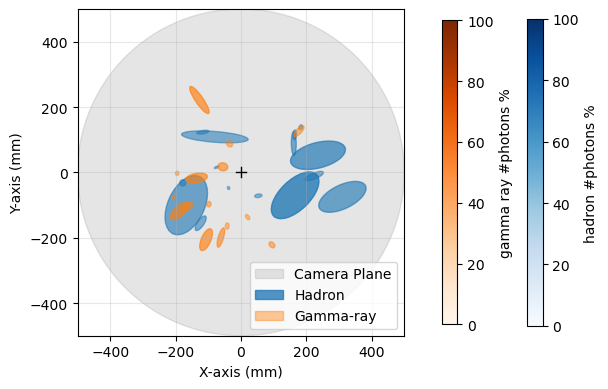

In [6]:
datasig = data[data['category'] == 'g'] 
databkg = data[data['category'] == 'h'] 
# visualize data
n_ellipses = 15

# ellipse parameters
random_angle_sig = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
sig_idx = np.random.randint(0,10000, size=n_ellipses)
sig_ellipse_params = [ 
    {
        'center': (datasig['fDist'][idx] * np.cos(random_angle_sig[i]), datasig['fDist'][idx] * np.sin(random_angle_sig[i])),  
        'width': datasig['fWidth'][idx], 
        'height': datasig['fLength'][idx], 
        'angle': datasig['fAlpha'][idx],
        'alpha': datasig['fSize'][idx]/data['fSize'].max()
        } 
    for i, idx in enumerate(sig_idx)
    ]

random_angle_bkg = 2 * np.pi * np.random.uniform(0, 1, size=n_ellipses)
bkg_idx = np.random.randint(13000,19000, size=n_ellipses)
bkg_ellipse_params = [ 
    {
        'center': (databkg['fDist'][idx] * np.cos(random_angle_bkg[i]), databkg['fDist'][idx] * np.sin(random_angle_bkg[i])),
        'width': databkg['fWidth'][idx], 
        'height': databkg['fLength'][idx], 
        'angle': databkg['fAlpha'][idx],
        'alpha': databkg['fSize'][idx]/data['fSize'].max()
        } 
    for i, idx in enumerate(bkg_idx)
    ]

fig, ax = plt.subplots(figsize=(6,8))

ax.grid(alpha=0.3)

# plot ellipses
radius = 500
camera_circle = patches.Circle((0,0), radius, alpha=0.2, color='grey')
ax.add_patch(camera_circle)

bkg_ellipses = []
sig_ellipses = []

for params in bkg_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi), 
        fill=True, 
        alpha=params['alpha'], 
        color='C0'
        )
    ax.add_patch(ellipse)
    bkg_ellipses.append(ellipse)

for params in sig_ellipse_params:
    ellipse = patches.Ellipse(
        xy=params['center'], 
        width=params['width'], 
        height=params['height'], 
        angle=(params['angle'] - 90 + 180*np.arctan(params['center'][1] / params['center'][0])/np.pi),
        alpha=params['alpha'], 
        color='C1'
        )
    ax.add_patch(ellipse)
    sig_ellipses.append(ellipse)

ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

legend_labels = ['Camera Plane', 'Hadron', 'Gamma-ray']
legend_handles = [camera_circle, bkg_ellipses[0], sig_ellipses[0]]
ax.legend(legend_handles, legend_labels, loc='lower right')

center_cross_size = 15
ax.plot([0, 0], [-center_cross_size, center_cross_size], color='black', linewidth=1)
ax.plot([-center_cross_size, center_cross_size], [0, 0], color='black', linewidth=1)

# color scale indicating alpha for background ellipses
bkg_alphas = [params['alpha'] for params in bkg_ellipse_params]
bkg_norm = Normalize(vmin=0, vmax=100)
bkg_scalar_map = ScalarMappable(norm=bkg_norm, cmap='Blues')
bkg_scalar_map.set_array(bkg_alphas)
bkg_colorbar = plt.colorbar(bkg_scalar_map, ax=ax, fraction=0.033, pad = 0.15)
bkg_colorbar.set_label('hadron #photons %')

# color scale indicating alpha for signal ellipses
sig_alphas = [params['alpha'] for params in sig_ellipse_params]
sig_norm = Normalize(vmin=0, vmax=100)
sig_scalar_map = ScalarMappable(norm=sig_norm, cmap='Oranges')
sig_scalar_map.set_array(sig_alphas)
sig_colorbar = plt.colorbar(sig_scalar_map, ax=ax, fraction=0.04, pad = 0.1)
sig_colorbar.set_label('gamma ray #photons %')

ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')

plt.show();

### Part 1.2 plot of the features 
the following code plots histograms for each feature, in red there are gammas (signal), in blue hadrons (background). The code saves the histograms in a directory named 'part_1_plots'

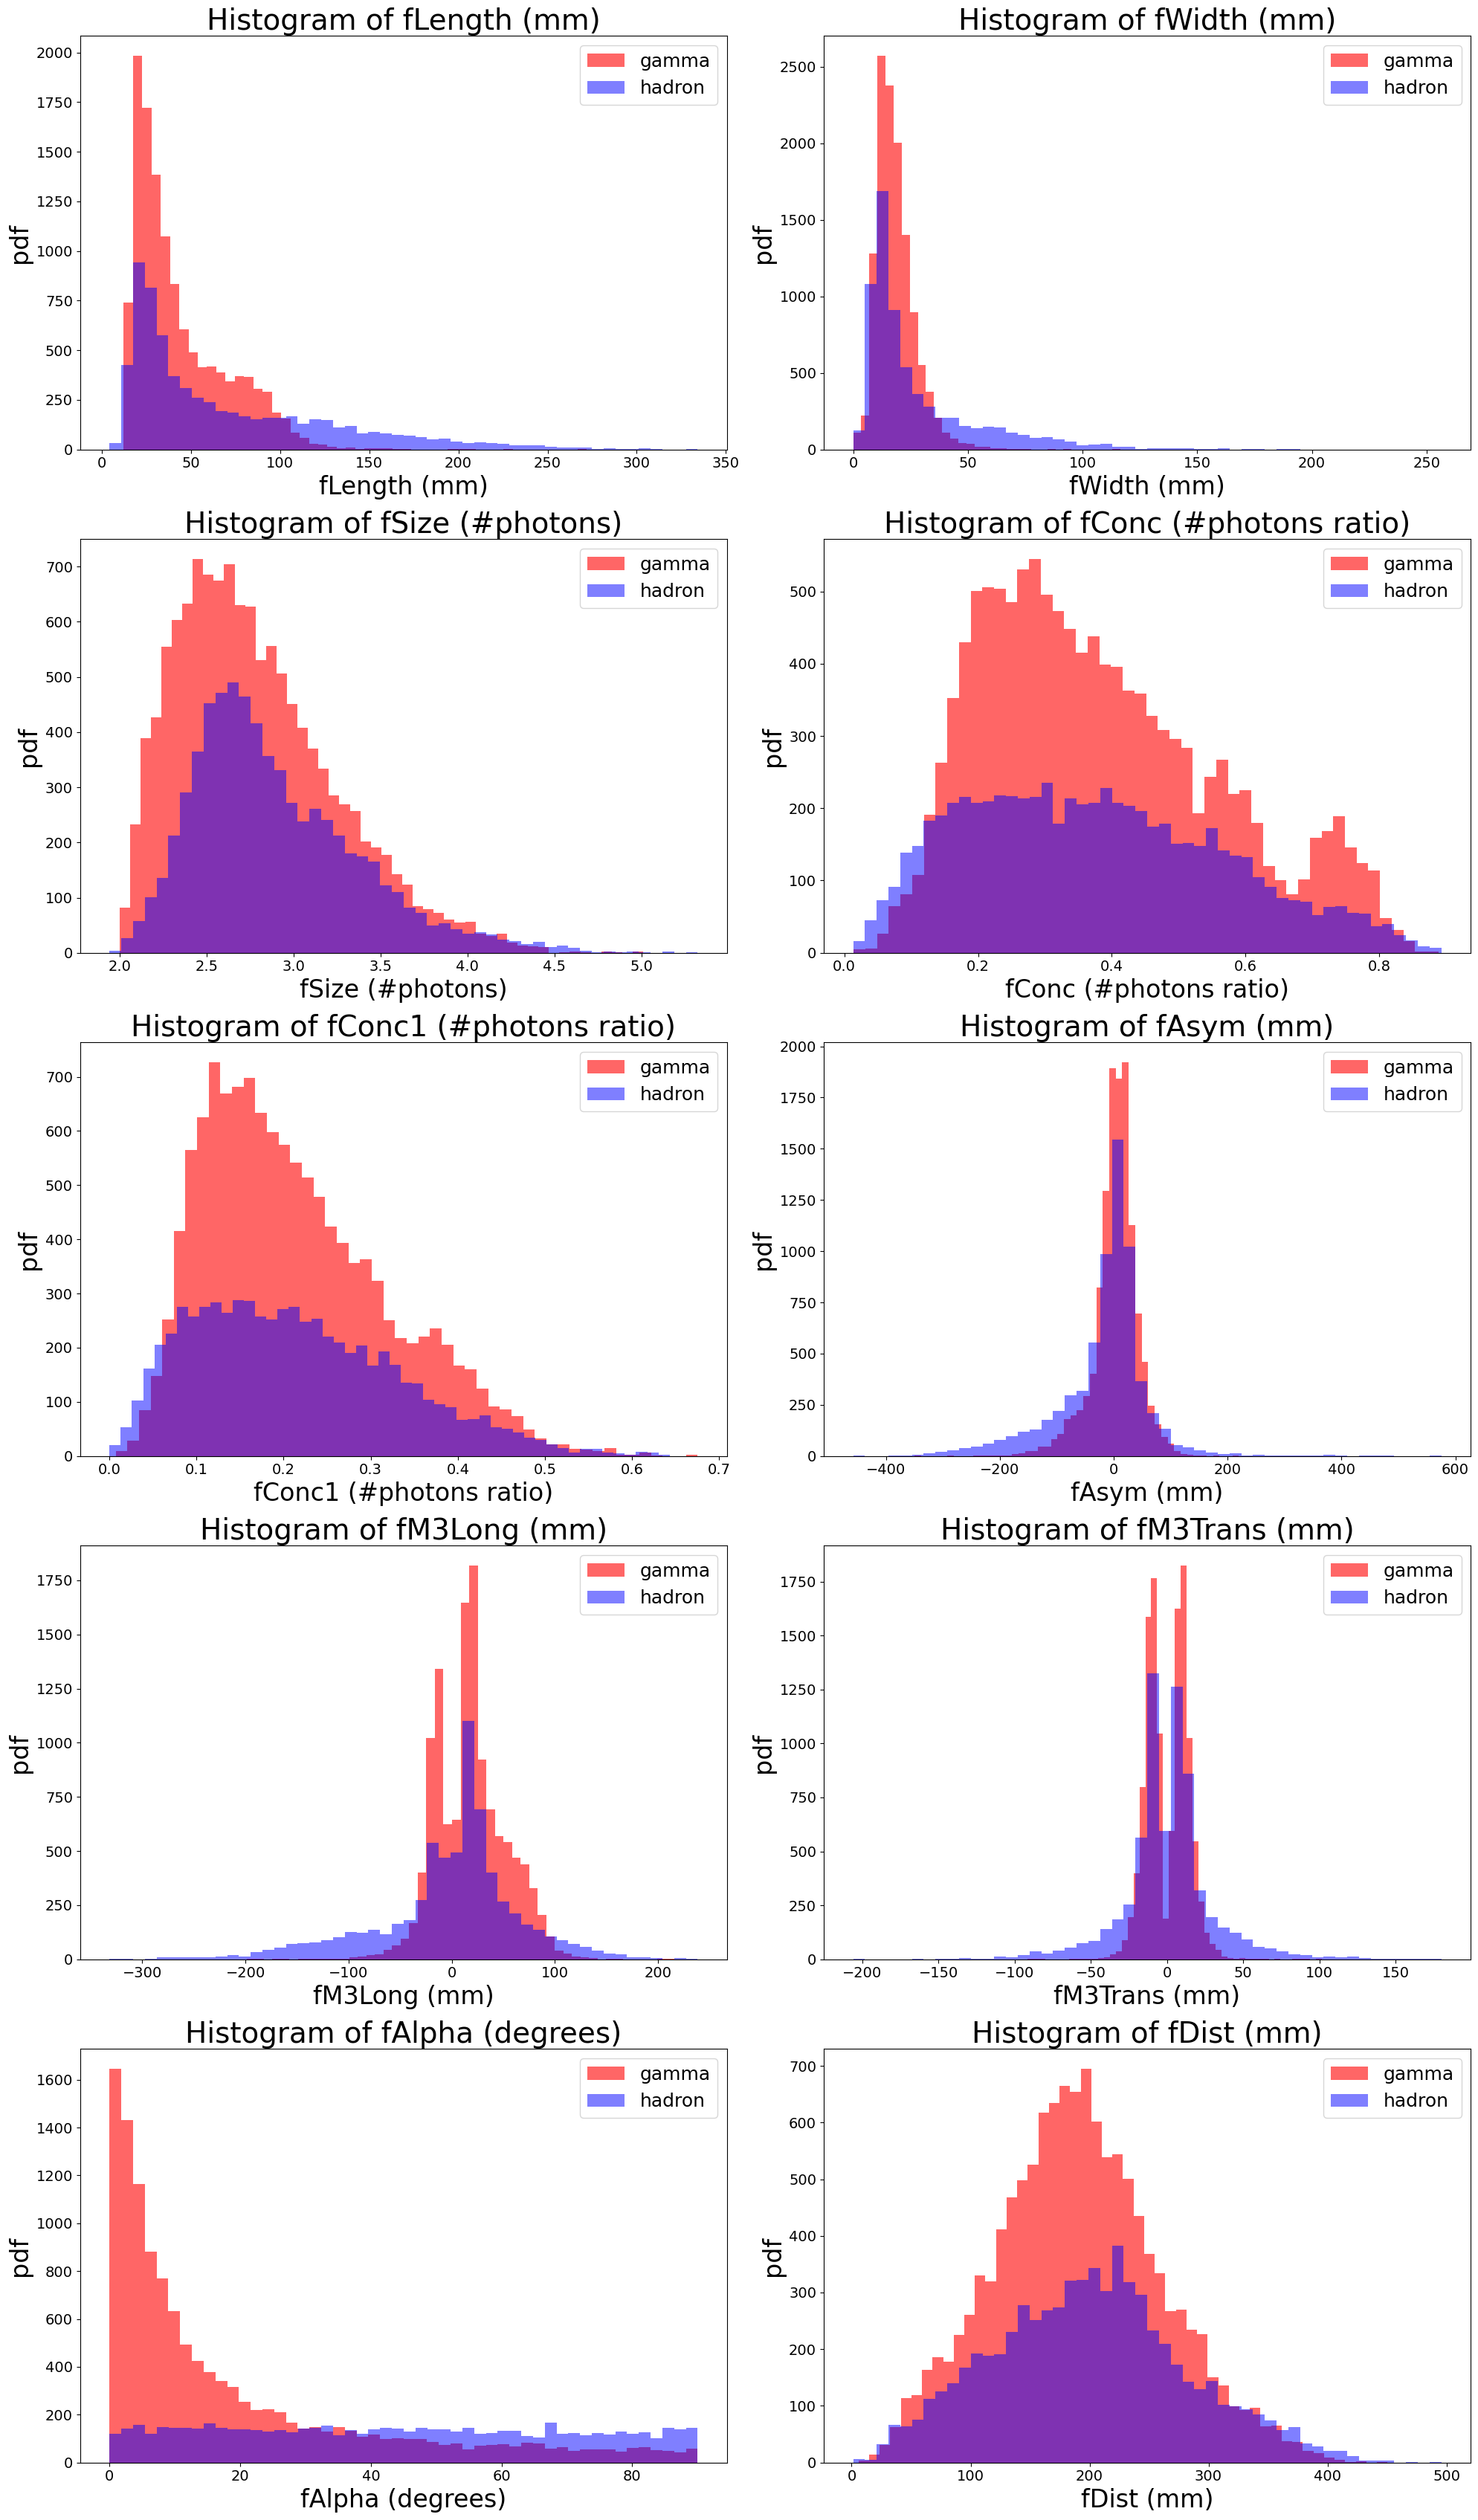

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 34))
udm = ['fLength (mm)', 'fWidth (mm)', 'fSize (#photons)', 'fConc (#photons ratio)', 'fConc1 (#photons ratio)', 
       'fAsym (mm)', 'fM3Long (mm)', 'fM3Trans (mm)', 'fAlpha (degrees)', 'fDist (mm)']
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
            'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
bins = 50

for i in range(5):
    for j in range(2):
        idx = 2 * i + j  # Update index to match new layout

        '''if datasig[features[idx]].std() < 1:
            siglabel = f'signal mean: {datasig[features[idx]].mean():.2f}±{datasig[features[idx]].std():.2f}'
            bkglabel = f'bkg mean: {databkg[features[idx]].mean():.2f}±{databkg[features[idx]].std():.2f}'
        else:
            siglabel = f'signal mean: {datasig[features[idx]].mean():.0f}±{datasig[features[idx]].std():.0f}'
            bkglabel = f'bkg mean: {databkg[features[idx]].mean():.0f}±{databkg[features[idx]].std():.0f}'''

        counts_sig, _ = np.histogram(datasig[features[idx]], bins=bins, density=True)
        counts_bkg, _ = np.histogram(databkg[features[idx]], bins=bins, density=True)

        ax[i][j].hist(x=datasig[features[idx]], bins=bins, alpha=0.6, color='red',label='gamma')
        ax[i][j].hist(x=databkg[features[idx]], bins=bins, alpha=0.5, color='blue',label='hadron')

        '''ax[i][j].vlines(x=datasig[features[idx]].mean(), ymin=0, ymax=counts_sig.max(), label=siglabel, color='red')
        ax[i][j].vlines(x=databkg[features[idx]].mean(), ymin=0, ymax=counts_bkg.max(), label=bkglabel, color='C0')'''
        ax[i][j].set_xlabel(udm[idx], fontsize=24)
        ax[i][j].set_ylabel('pdf', fontsize=24)
        ax[i][j].tick_params(axis='both', which='major', labelsize=14)
        ax[i][j].legend(loc='best', fontsize=18)
        ax[i][j].set_title(f'Histogram of {udm[idx]}', fontsize=28)


plt.tight_layout()
plt.show()


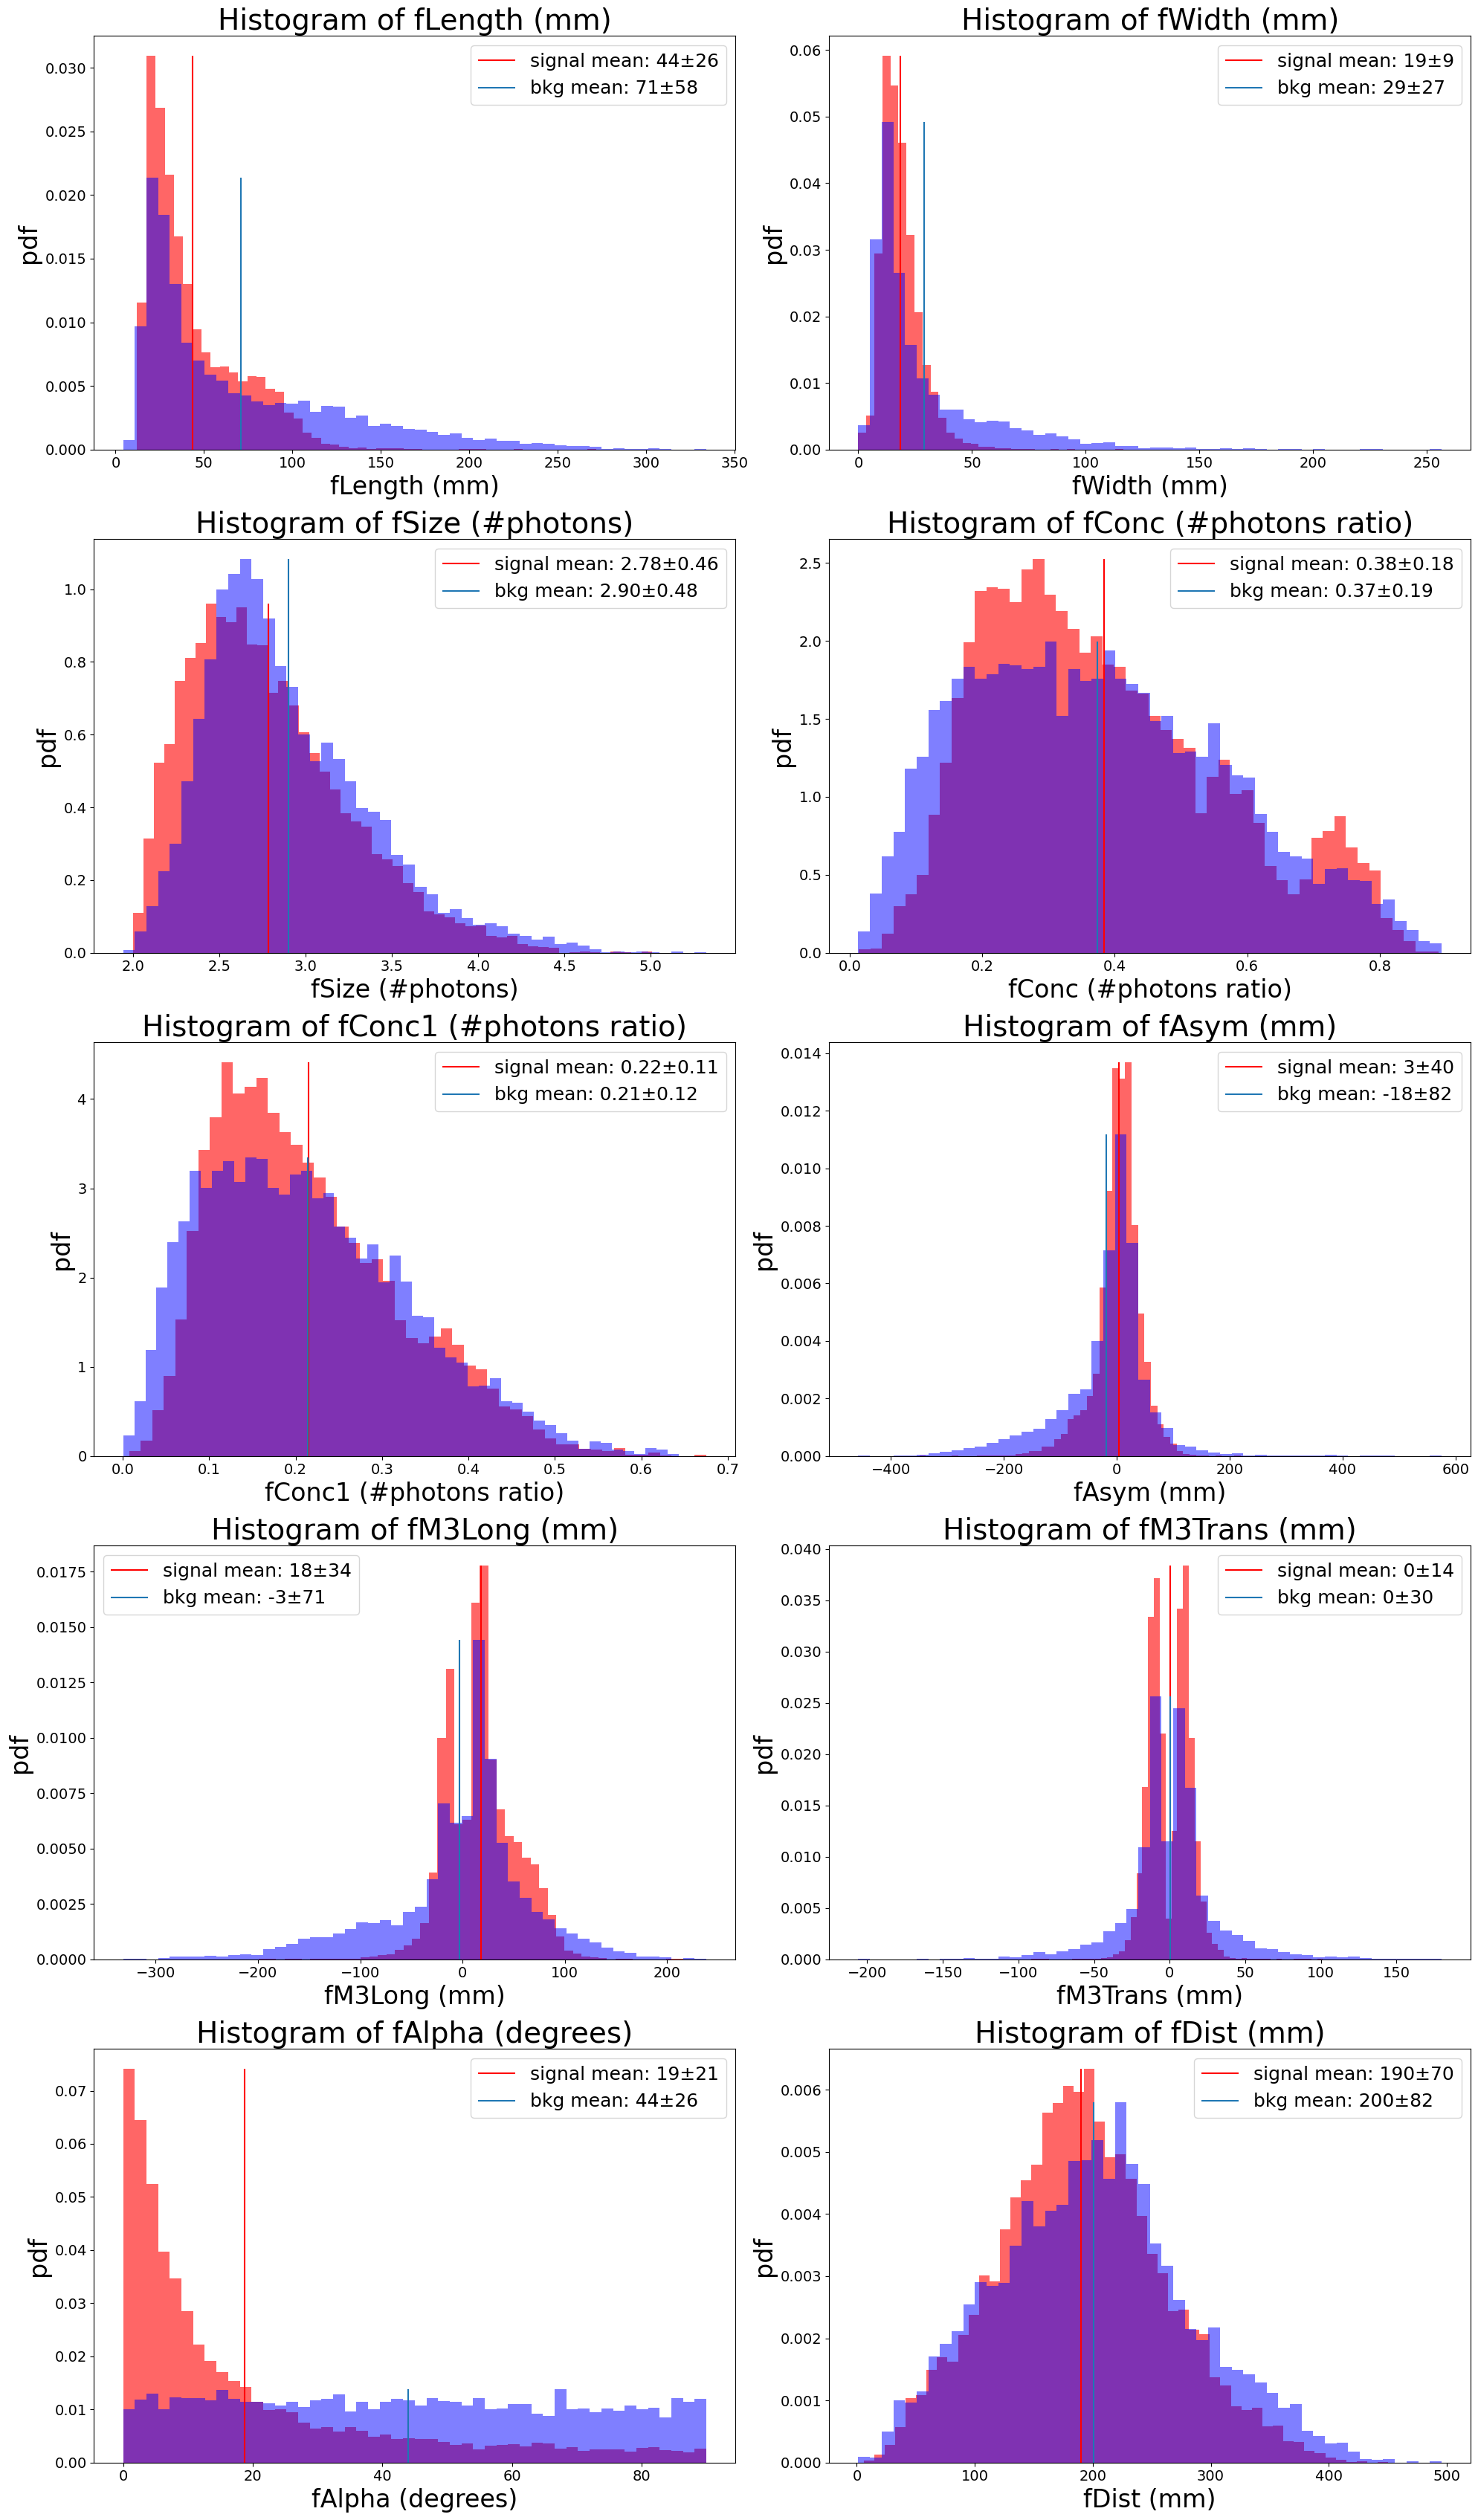

In [8]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 34))
udm = ['fLength (mm)', 'fWidth (mm)', 'fSize (#photons)', 'fConc (#photons ratio)', 'fConc1 (#photons ratio)', 
       'fAsym (mm)', 'fM3Long (mm)', 'fM3Trans (mm)', 'fAlpha (degrees)', 'fDist (mm)']
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
            'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
bins = 50

for i in range(5):
    for j in range(2):
        idx = 2 * i + j  # Update index to match new layout

        if datasig[features[idx]].std() < 1:
            siglabel = f'signal mean: {datasig[features[idx]].mean():.2f}±{datasig[features[idx]].std():.2f}'
            bkglabel = f'bkg mean: {databkg[features[idx]].mean():.2f}±{databkg[features[idx]].std():.2f}'
        else:
            siglabel = f'signal mean: {datasig[features[idx]].mean():.0f}±{datasig[features[idx]].std():.0f}'
            bkglabel = f'bkg mean: {databkg[features[idx]].mean():.0f}±{databkg[features[idx]].std():.0f}'

        counts_sig, _ = np.histogram(datasig[features[idx]], bins=bins, density=True)
        counts_bkg, _ = np.histogram(databkg[features[idx]], bins=bins, density=True)

        ax[i][j].hist(x=datasig[features[idx]], bins=bins, density=True, alpha=0.6, color='red')
        ax[i][j].hist(x=databkg[features[idx]], bins=bins, density=True, alpha=0.5, color='blue')

        ax[i][j].vlines(x=datasig[features[idx]].mean(), ymin=0, ymax=counts_sig.max(), label=siglabel, color='red')
        ax[i][j].vlines(x=databkg[features[idx]].mean(), ymin=0, ymax=counts_bkg.max(), label=bkglabel, color='C0')
        ax[i][j].set_xlabel(udm[idx], fontsize=24)
        ax[i][j].set_ylabel('pdf', fontsize=24)
        ax[i][j].tick_params(axis='both', which='major', labelsize=14)
        ax[i][j].legend(loc='best', fontsize=18)
        ax[i][j].set_title(f'Histogram of {udm[idx]}', fontsize=28)


plt.tight_layout()
plt.show()


We observe that the mean values of all features for hadrons and gammas are compatible. Also they distribute in similar shapes, except for `fAlpha`. Therefore is not possible to distinguish signal from background from the distributions. 

# Part 2: studying the correlations
in this section each feature will be confronted with all the others. Results will be put in a 2D correlation matrix (n_features x n_features) to visualize the results

First we rescale all features to have average = 0 and dev_std = 1 (except Alpha)

In [9]:
X = data[['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist']]
Y = data['category']
print(X['fAlpha'])


0         6.3609
1        76.9600
2        10.4490
3         4.6480
4         3.6130
          ...   
19014     2.4229
19015    86.7975
19016    30.2987
19017    84.6874
19018    52.7310
Name: fAlpha, Length: 19019, dtype: float64


In [10]:
X_rescaled = X.copy()
original_alpha = X['fAlpha'].copy()

for i in range(X.shape[1]):
    h = X[str(X.columns[i])]
    avg = np.average(h)
    std = np.std(h)
    h = h - avg
    h = h / std
    X_rescaled[str(X_rescaled.columns[i])] = h
    
print('media length:',np.average(X_rescaled['fLength']))
print('dev_std length:',np.std(X_rescaled['fLength']))

media length: 3.5865241407523854e-17
dev_std length: 0.9999999999999971


The following cell computes the correlation matrix taking apart gammas from hadrons

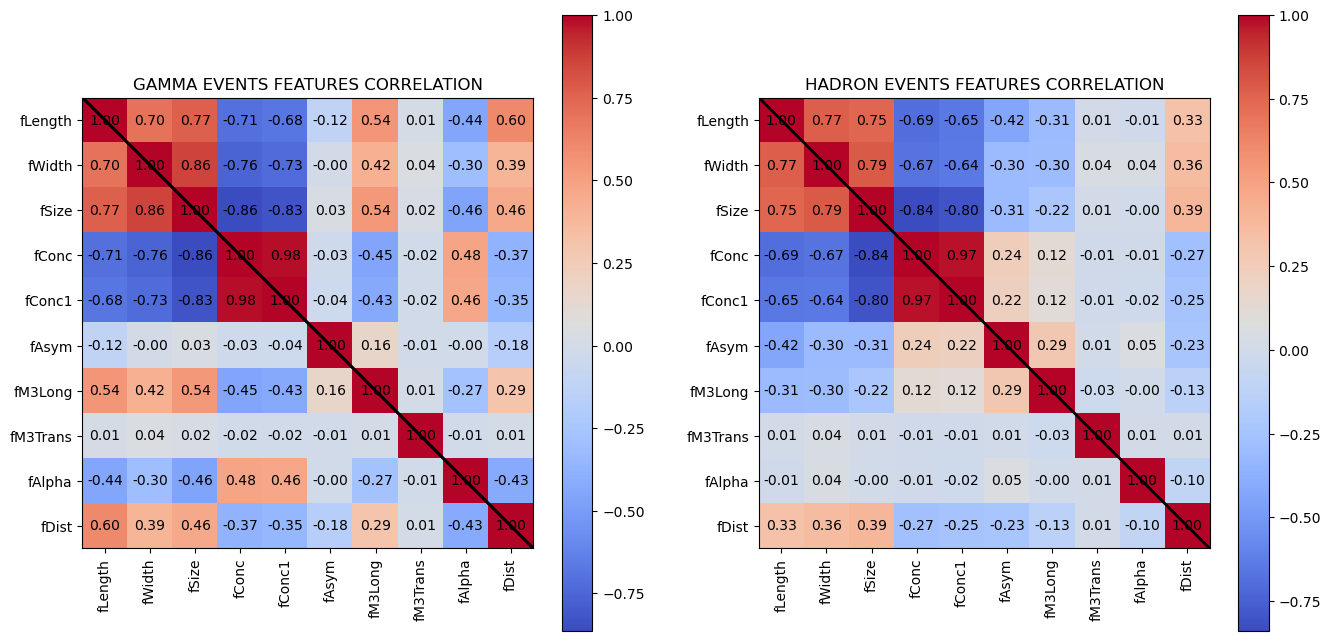

In [11]:
Xg_rescaled = X_rescaled[Y == 'g']
Xh_rescaled = X_rescaled[Y == 'h']
features = features[:10]


cov = np.zeros((Xg_rescaled.shape[1],Xg_rescaled.shape[1]))
for i in range(Xg_rescaled.shape[1]):
    h = Xg_rescaled[str(Xg_rescaled.columns[i])]
    for j in range(Xg_rescaled.shape[1]):
        v = Xg_rescaled[str(Xg_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xg_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs) # the data for gamma events are not normalized with respsect to themselv   



ticks = np.arange(0,10,1)
x_ticks = np.arange(cov.shape[1]) + 0.5
y_ticks = np.arange(cov.shape[0]) + 0.5

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cax = ax[0].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[0].set_xticks(ticks, minor=False)
ax[0].set_yticks(ticks, minor=False)
ax[0].set_xticklabels(features,rotation=90)
ax[0].set_yticklabels(features)
ax[0].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[0].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[0].set_title('GAMMA EVENTS FEATURES CORRELATION')

cov = np.zeros((Xh_rescaled.shape[1],Xh_rescaled.shape[1]))
for i in range(Xh_rescaled.shape[1]):
    h = Xh_rescaled[str(Xh_rescaled.columns[i])]
    for j in range(Xh_rescaled.shape[1]):
        v = Xh_rescaled[str(Xh_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xh_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs)

cax = ax[1].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[1].set_xticks(ticks, minor=False)
ax[1].set_yticks(ticks, minor=False)
ax[1].set_xticklabels(features, rotation=90)
ax[1].set_yticklabels(features)
ax[1].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[1].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[1].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[1].set_title('HADRON EVENTS FEATURES CORRELATION')

plt.show();

We observe that the most correlated features are the first 3. Their correlation is positive, while correlation between `fConc1` and `fConc2` is negative, and very close to 1. 

## Part 2.1: Correlation between features and label

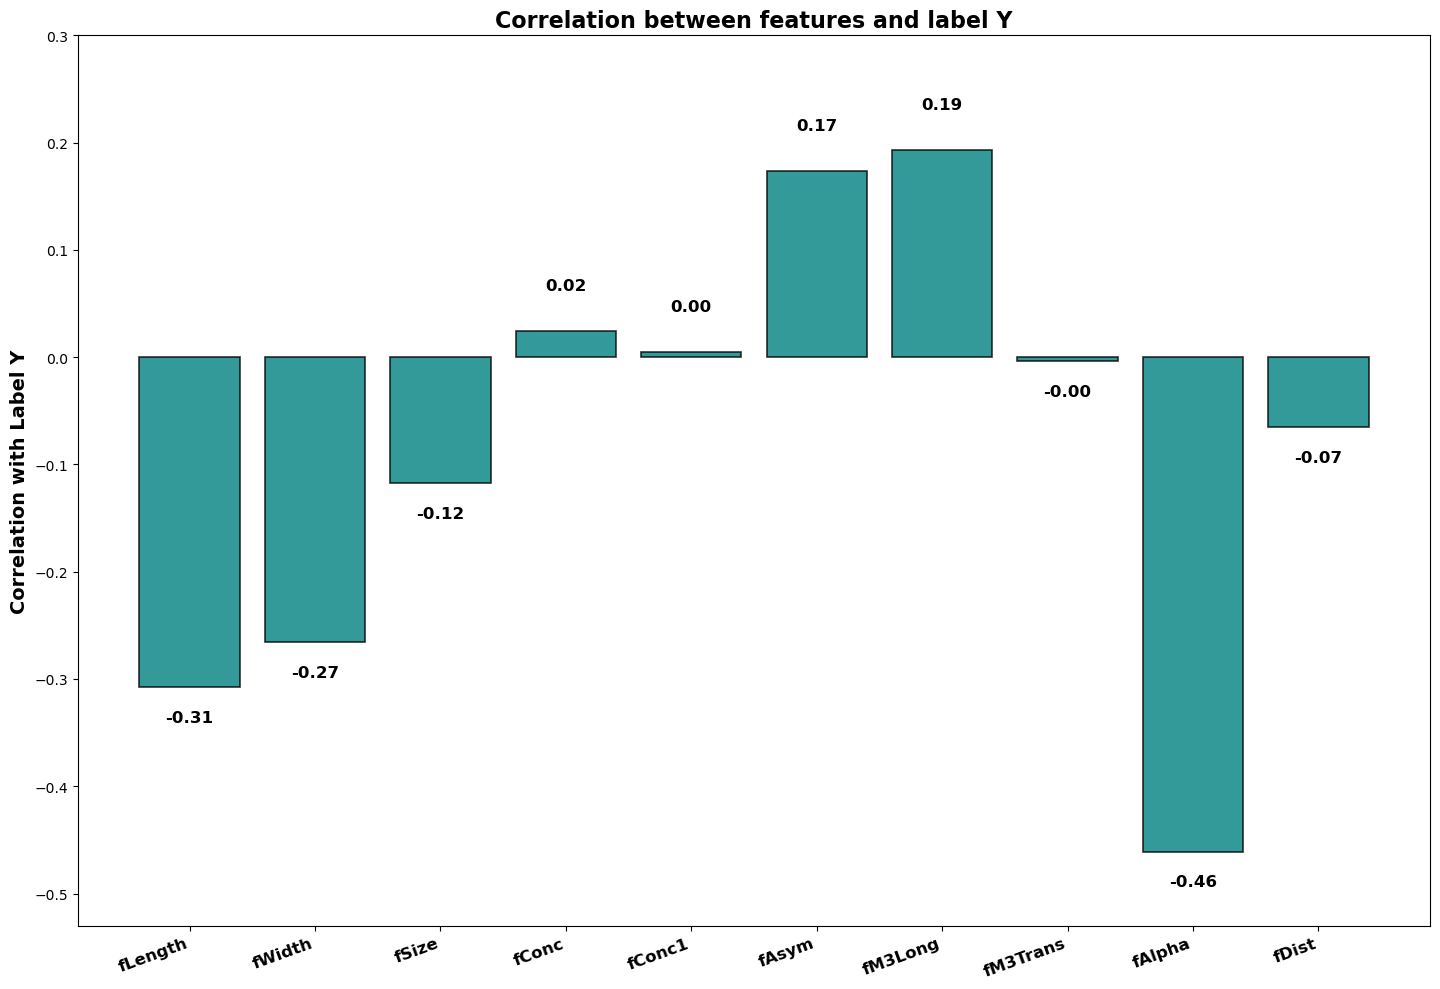

In [12]:
# Calculate the correlation between each feature and the label Y

Y_array = np.where(Y == 'g', 1, -1)
Y_array = np.array(Y_array) 
feature_names = data.columns[:10]

correlations = np.zeros(X_rescaled.shape[1])  
for i in range(X_rescaled.shape[1]):
    feature = X_rescaled.iloc[:, i]  
    correlations[i] = np.corrcoef(feature, Y_array)[0, 1]

# create a bar plot to display the correlations
fig, ax = plt.subplots(figsize=(14.5, 10))

bars = ax.bar(feature_names, correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation with Label Y', fontsize=14, fontweight='bold')
ax.set_ylim(-0.53,0.3)
ax.set_title('Correlation between features and label Y', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, fontsize=12, fontweight='bold', rotation=20, ha='right')
plt.tight_layout()
plt.show()

The features most strongly correlated with the label Y, and thus most informative for distinguishing between gamma and hadron events, are 𝐴𝑙𝑝ℎ𝑎
, 𝐿𝑒𝑛𝑔𝑡ℎ and 𝑊𝑖𝑑𝑡ℎ. This is coherent with our observations from the feature histograms, where these features exhibit more distinct distributions between the two classes.

# Part 3: comparison of the features rescaled

In this section we analyze the distributions of the "fWidth" and "fLength" parameters. First of all we have computed the mean and standard deviation for both samples and we rescaled them. Then the distribution of both "fWidth" and "fLength" was plotted dividing the gamma from the hadron events.

We then used the "fSize" parameter to apply a cut to both the signals (gamma) and background (hadron) events and considered only the tails of their distribution. Since "fSize" is proportional to the number of photons, for both the width and lenght distribution we defined as "High energy events" the data points higher than 𝜇+𝜎
(right-side tail) and as "Low energy events" the data points lower than 𝜇−𝜎. Considering 𝜇 and 𝜎

rispectively as the mean and standard deviation of the rescaled width and lenght distributions.

From this comparison we can clearly see that in the high energy tail the signal is more clustered and separated from the background, despite having a smaller number of gamma events in this energy region. Meanwhile in the low energy tail signal and background events are more evenly distributed.

Therefore,considering only the high energy region could give us an edge while classifying the events into signal and background.

In [13]:
## find mean and std

mu_l=data['fLength'].mean()
std_l=data['fLength'].std()
mu_w=data['fWidth'].mean()
std_w=data['fWidth'].std()
print('Length attribute:   mean = ', round(mu_l,3), '    std = ', round(std_l,3))
print('Width attribute:    mean = ', round(mu_w,3), '   std = ', round(std_w,3))
data['scaled_fLength']= (data['fLength']-mu_l)/std_l   ##add a scaled comlumn to the DataFrame
data['scaled_fWidth']= (data['fWidth']-mu_w)/std_w  

Length attribute:   mean =  53.251     std =  42.366
Width attribute:    mean =  22.181    std =  18.346


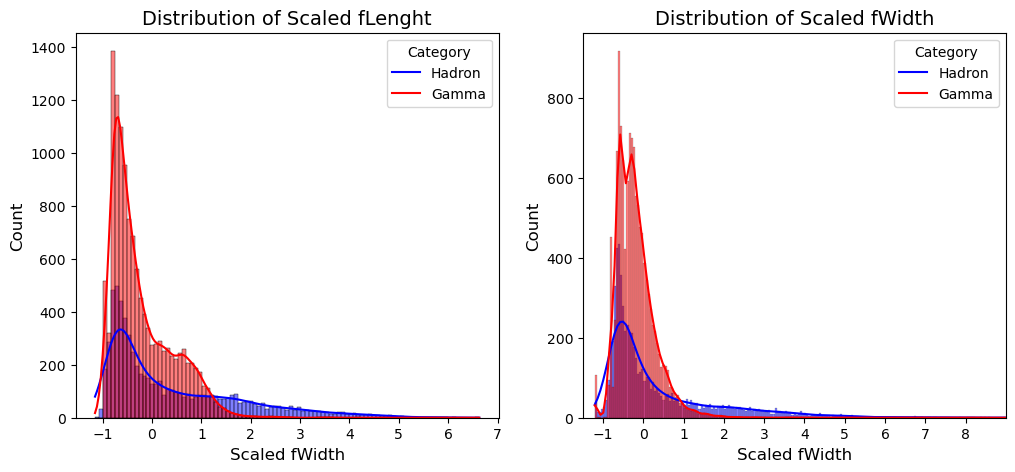

In [14]:
###plots of the scaled distribution before cutting 

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(data,x=data['scaled_fLength'],hue='category', kde=True, ax=ax[0], palette=['red','blue'],edgecolor='black')
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fWidth", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
legend = ax[0].get_legend()

ax[0].legend(['Hadron', 'Gamma'], title='Category')


sns.histplot(data,x=data['scaled_fWidth'],hue='category', kde=True, ax=ax[1], palette=['red','blue'],edgecolor='black')
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fWidth", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xticks(range(-1,9))
ax[1].set_xlim(-1.5, 9)  
legend = ax[1].get_legend()
ax[1].legend(['Hadron', 'Gamma'], title='Category');


In [15]:
median_fSize = data['fSize'].median()
min_fSize = data['fSize'].min()
max_fSize = data['fSize'].max()
mean_fSize = data['fSize'].mean()
std_fSize = data['fSize'].std()
print("Statistichal informations of fSize: \nmedian=",median_fSize, '\nmin=', min_fSize, '\nmax=', max_fSize, '\nmean=', round(mean_fSize,3), '\nstd=', round(std_fSize,3))


Statistichal informations of fSize: 
median= 2.7396 
min= 1.9413 
max= 5.3233 
mean= 2.825 
std= 0.473


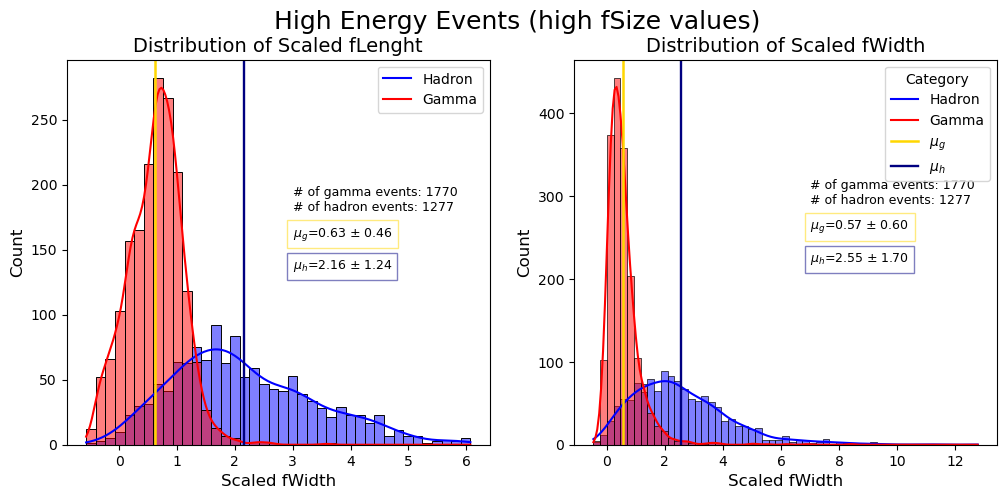

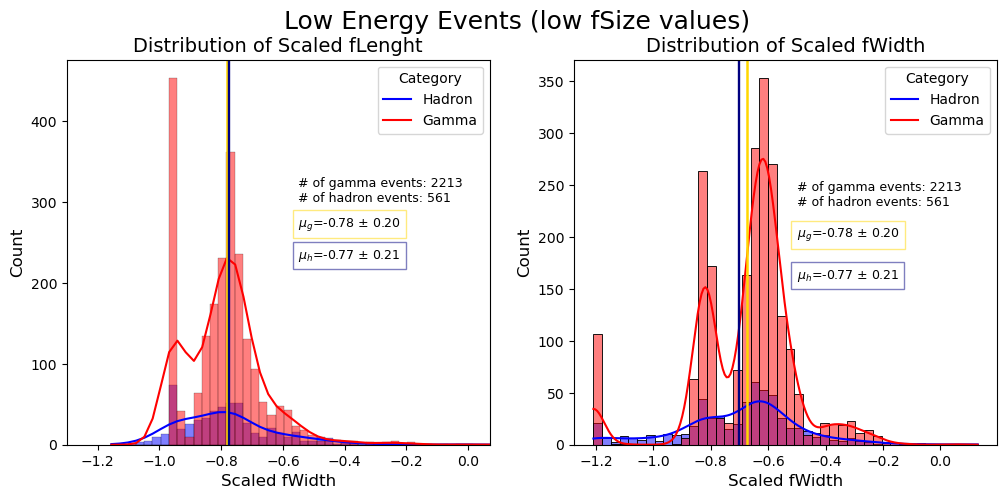

In [16]:
#### plots at high energy

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('High Energy Events (high fSize values)', fontsize=18)

##useful variables
ng_high=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
nh_high=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize])
l_mu_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_mu_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].mean()
l_std_g_high=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
l_std_h_high=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize].std()
w_mu_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_mu_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].mean()
w_std_g_high=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()
w_std_h_high=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize].std()

##plot length - high energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] >= mean_fSize+std_fSize],hue='category',hue_order=['g', 'h'], kde=True, color='blue', ax=ax[0], palette=['red','blue'],edgecolor='black')
ax[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax[0].set_xlabel("Scaled fWidth", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].axvline(l_mu_g_high,c='gold', label= r'$\mu_{g}$', lw=1.8)
ax[0].axvline(l_mu_h_high,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[0].get_legend()
ax[0].legend(['Hadron', 'Gamma'])
ax[0].text(x=3,y=180,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[0].text(x=3,y=160,s=fr"$\mu_{{g}}$={l_mu_g_high:.2f} $\pm$ {l_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='gold'))
ax[0].text(x=3,y=135,s=fr"$\mu_{{h}}$={l_mu_h_high:.2f} $\pm$ {l_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#plot width - high energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] >= mean_fSize+std_fSize],hue='category', kde=True, color='blue', ax=ax[1], palette=['red','blue'],edgecolor='black')
ax[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax[1].set_xlabel("Scaled fWidth", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].axvline(w_mu_g_high,c='gold', label= r'$\mu_{g}$', lw=1.8)
ax[1].axvline(w_mu_h_high,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()
ax[1].legend(['Hadron', 'Gamma', r'$\mu_{g}$', r'$\mu_{h}$'], title='Category')
ax[1].text(x=7,y=290,s=f"# of gamma events: {ng_high} \n# of hadron events: {nh_high}", fontsize=9, color='black')
ax[1].text(x=7,y=260,s=fr"$\mu_{{g}}$={w_mu_g_high:.2f} $\pm$ {w_std_g_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='gold'))
ax[1].text(x=7,y=220,s=fr"$\mu_{{h}}$={w_mu_h_high:.2f} $\pm$ {w_std_h_high:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

#### plots at low energy

fig1, ax1 = plt.subplots(1, 2, figsize=(12,5))
fig1.suptitle('Low Energy Events (low fSize values)', fontsize=18)

###useful variables
ng_low=len(data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
nh_low=len(data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize])
l_mu_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_mu_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].mean()
l_std_g_low=data[data['category'] == 'g']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
l_std_h_low=data[data['category'] == 'h']['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize].std()
w_mu_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_mu_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].mean()
w_std_g_low=data[data['category'] == 'g']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()
w_std_h_low=data[data['category'] == 'h']['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize].std()

## plot length - low energy
sns.histplot(data,x=data['scaled_fLength'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=True, color='blue', ax=ax1[0], palette=['red','blue'],edgecolor='black', bins=200)
ax1[0].set_title("Distribution of Scaled fLenght", fontsize=14)
ax1[0].set_xlabel("Scaled fWidth", fontsize=12)
ax1[0].set_ylabel("Count", fontsize=12)
ax1[0].axvline(l_mu_g_low,c='gold', label= r'$\mu_{g}$', lw=1.8)
ax1[0].axvline(l_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[0].get_legend()
ax1[0].legend(['Hadron', 'Gamma'], title='Category')
ax1[0].set_xlim(-1.3,0.07)
ax1[0].text(x=-0.55,y=300,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low} ", fontsize=9, color='black')
ax1[0].text(x=-0.55,y=270,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='gold'))
ax1[0].text(x=-0.55,y=230,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))

## plot width - low energy
sns.histplot(data,x=data['scaled_fWidth'][data['fSize'] <= mean_fSize-std_fSize],hue='category', kde=True, color='blue', ax=ax1[1], palette=['red','blue'],edgecolor='black')
ax1[1].set_title("Distribution of Scaled fWidth", fontsize=14)
ax1[1].set_xlabel("Scaled fWidth", fontsize=12)
ax1[1].set_ylabel("Count", fontsize=12)
ax1[1].axvline(w_mu_g_low,c='gold', label= r'$\mu_{g}$', lw=1.8)
ax1[1].axvline(w_mu_h_low,c='navy',label=r'$\mu_{h}$', lw=1.7)
legend = ax[1].get_legend()
ax1[1].legend(['Hadron', 'Gamma'], title='Category')
ax1[1].text(x=-0.5,y=230,s=f"# of gamma events: {ng_low} \n# of hadron events: {nh_low}", fontsize=9, color='black')
ax1[1].text(x=-0.5,y=200,s=fr"$\mu_{{g}}$={l_mu_g_low:.2f} $\pm$ {l_std_g_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='gold'))
ax1[1].text(x=-0.5,y=160,s=fr"$\mu_{{h}}$={l_mu_h_low:.2f} $\pm$ {l_std_h_low:.2f}", fontsize=9, color='black',  bbox=dict(facecolor='white', alpha=0.5, edgecolor='navy'))


plt.show();

# Part 4: PCA

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import linalg as la

!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data.7"
data = pd.DataFrame(pd.read_csv(file_name))

df= pd.DataFrame(data.values, columns=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])
df_1=df[df['class']=='g']
df_0=df[df['class']=='h']
df_1 = df_1.drop(columns=['class']) # no need for label to perform PCA
df_0 = df_0.drop(columns=['class']) 

print("Shape of df_1:",np.shape(df_1))
print("Shape of df_0:",np.shape(df_0))


Shape of df_1: (12331, 10)
Shape of df_0: (6688, 10)


In [18]:
# We re-scale the data-set to mean zero and unitary std before executing the PCA   
for column in df_1.columns: 
    mean =df_1[column].mean()
    std= df_1[column].std()
    df_1[column]= (df_1[column]-mean)/std
for column in df_0.columns: 
    mean =df_0[column].mean()
    std= df_0[column].std()
    df_0[column]= (df_0[column]-mean)/std

In [19]:
df_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.46046,-0.760816,-0.573381,0.823995,1.527718,0.581262,0.177195,-0.748903,-0.578221,0.213696
1,4.523403,13.006763,2.757867,-1.94532,-1.848775,2.86389,-2.435386,-3.350675,2.708118,0.946671
2,-0.757944,-0.999015,-0.962066,1.298189,1.668012,0.604942,-0.715068,-0.541838,-0.387922,-1.045563
3,1.202731,1.365333,0.814225,-0.375535,-0.299882,-0.221084,0.316503,1.597412,-0.657955,2.36454
4,0.304432,0.283231,0.26877,-0.795793,-0.763137,1.202046,0.747688,0.710088,-0.706133,0.680804
...,...,...,...,...,...,...,...,...,...,...
12326,-1.176177,-0.791727,-0.870077,1.979703,1.557848,-0.462468,-0.368425,0.843377,0.103778,0.196285
12327,-0.641711,0.221696,0.197295,-0.223838,0.001423,-0.168803,-1.113903,-0.682203,-0.688826,0.217067
12328,-0.823883,-0.852587,-1.057078,0.867819,0.723612,0.303856,0.012389,0.531735,0.106385,-0.952475
12329,0.480086,0.012071,0.314549,-0.741856,-0.713234,2.3551,-1.741272,0.825343,-0.599163,0.099156


In [20]:
df_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
12331,0.392734,0.336335,0.509333,-1.078145,-0.955834,0.869326,1.300189,0.38302,-1.149281,0.384367
12332,0.535902,-0.249909,0.864505,-1.400203,-1.198949,-0.434994,0.649403,-0.515505,1.711764,0.910031
12333,0.506171,-0.254443,0.435676,-0.325283,-0.587349,-0.363269,0.855943,-0.333989,-0.892876,1.783286
12334,0.3574,-0.366573,-0.397221,0.336609,1.084807,-0.417957,-1.34382,-0.583383,0.765787,-0.850547
12335,-0.568118,-0.592947,-0.053908,0.178717,-0.179052,-0.403375,0.158383,0.254152,-0.748348,-0.446646
...,...,...,...,...,...,...,...,...,...,...
19014,-0.855161,-0.657545,-0.591972,1.105678,1.520212,0.407652,0.203334,0.084175,-1.59954,-1.143376
19015,-0.724699,-0.81255,-1.317922,0.841131,0.546058,0.672784,0.226829,-0.111018,1.647644,0.57434
19016,0.077684,0.688905,1.139571,-1.215647,-1.347189,0.108521,0.621122,-0.328377,-0.526731,0.68501
19017,0.855352,1.769025,2.274791,-1.462941,-1.233679,0.292734,-1.282777,-2.145759,1.566436,2.539158


In [21]:
cov_1 = df_1.cov()
cov_0 = df_0.cov()
cov_1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.695644,0.766118,-0.710209,-0.679994,-0.120212,0.542507,0.012337,-0.443232,0.602479
fWidth,0.695644,1.000000,0.855155,-0.761340,-0.731434,-0.002589,0.422045,0.044016,-0.296886,0.389206
fSize,0.766118,0.855155,1.000000,-0.863440,-0.825395,0.029039,0.540963,0.022622,-0.458023,0.459641
fConc,-0.710209,-0.761340,-0.863440,1.000000,0.979332,-0.033398,-0.452184,-0.017356,0.482322,-0.368592
fConc1,-0.679994,-0.731434,-0.825395,0.979332,1.000000,-0.037624,-0.433913,-0.016053,0.463536,-0.347123
fAsym,-0.120212,-0.002589,0.029039,-0.033398,-0.037624,1.000000,0.162435,-0.005598,-0.004571,-0.178190
fM3Long,0.542507,0.422045,0.540963,-0.452184,-0.433913,0.162435,1.000000,0.008234,-0.271465,0.294765
fM3Trans,0.012337,0.044016,0.022622,-0.017356,-0.016053,-0.005598,0.008234,1.000000,-0.007311,0.009752
fAlpha,-0.443232,-0.296886,-0.458023,0.482322,0.463536,-0.004571,-0.271465,-0.007311,1.000000,-0.425032
fDist,0.602479,0.389206,0.459641,-0.368592,-0.347123,-0.178190,0.294765,0.009752,-0.425032,1.000000


In [22]:
cov_0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.773884,0.747319,-0.688524,-0.651879,-0.423194,-0.307349,0.013007,-0.009282,0.325267
fWidth,0.773884,1.000000,0.790355,-0.672618,-0.638750,-0.304118,-0.296956,0.039519,0.041617,0.354997
fSize,0.747319,0.790355,1.000000,-0.839128,-0.796837,-0.305340,-0.223553,0.010992,-0.004228,0.394842
fConc,-0.688524,-0.672618,-0.839128,1.000000,0.972725,0.238806,0.124154,-0.007704,-0.010714,-0.267684
fConc1,-0.651879,-0.638750,-0.796837,0.972725,1.000000,0.220317,0.115716,-0.008235,-0.015137,-0.245179
fAsym,-0.423194,-0.304118,-0.305340,0.238806,0.220317,1.000000,0.285738,0.006849,0.053334,-0.229049
fM3Long,-0.307349,-0.296956,-0.223553,0.124154,0.115716,0.285738,1.000000,-0.026806,-0.001489,-0.131121
fM3Trans,0.013007,0.039519,0.010992,-0.007704,-0.008235,0.006849,-0.026806,1.000000,0.010832,0.013150
fAlpha,-0.009282,0.041617,-0.004228,-0.010714,-0.015137,0.053334,-0.001489,0.010832,1.000000,-0.097112
fDist,0.325267,0.354997,0.394842,-0.267684,-0.245179,-0.229049,-0.131121,0.013150,-0.097112,1.000000


In [23]:
l_1,V_1= la.eig(cov_1)
l_1=l_1.real
V_1=V_1.real
print("Eigenvalues Gamma events:", l_1,'\n')
print("Eigenvectors Gamma events:", V_1,'\n')

Eigenvalues Gamma events: [5.04135896 1.18671249 1.00189813 0.86259252 0.73828989 0.52867675
 0.01763177 0.10500615 0.29317529 0.22465805] 

Eigenvectors Gamma events: [[ 3.86563154e-01  1.64161550e-01 -1.87852855e-02 -5.17321758e-02
   2.27306595e-01 -6.21165157e-02  1.64670468e-02  2.62838530e-02
  -3.75283692e-02  8.73323351e-01]
 [ 3.76614052e-01 -6.58692554e-02  5.96665086e-02  3.13862948e-01
   9.53882263e-02 -2.55432045e-01 -4.24256844e-03  4.90484637e-01
  -6.23609927e-01 -2.18920288e-01]
 [ 4.17121017e-01 -7.65050692e-02  1.22260020e-02  1.38753617e-01
   1.93685374e-02 -6.00347575e-02  1.05957925e-01 -8.36960174e-01
  -2.44851708e-01 -1.58410555e-01]
 [-4.09538760e-01  1.17040480e-01 -9.64678415e-03 -2.30228965e-01
   2.25834045e-01 -6.25170832e-02  7.50095221e-01 -4.79749462e-02
  -3.77875580e-01  5.32663335e-02]
 [-3.98738464e-01  1.26974491e-01 -9.56015222e-03 -2.43724055e-01
   2.46152389e-01 -7.37984117e-02 -6.52335699e-01 -1.94150192e-01
  -4.81400557e-01  6.61244443e-0

In [24]:
l_0,V_0= la.eig(cov_0)
l_0=l_0.real
V_0=V_0.real
print("Eigenvalues background events:", l_0,'\n')
print("Eigenvectors background events:", V_0,'\n')

Eigenvalues background events: [4.42388448 0.02391582 0.14984033 0.2221564  0.43740477 1.20808117
 0.69931975 0.80384168 1.03760086 0.99395472] 

Eigenvectors background events: [[-4.13567164e-01 -2.63725151e-02 -1.06784542e-01  7.64522513e-01
  -4.62230622e-01 -8.23597651e-02 -5.41729191e-02  7.12962716e-02
   4.76672675e-02 -4.04817037e-02]
 [-4.10369824e-01  1.18010294e-02  4.74225410e-01 -4.98487549e-01
  -5.76267380e-01 -9.62312079e-03  1.32890905e-01 -2.68784361e-02
   8.66124162e-02 -4.11274819e-03]
 [-4.39407630e-01 -1.02147327e-01 -8.06450398e-01 -3.56019314e-01
  -3.84986171e-02  1.09655517e-01  5.96543774e-02 -1.63618469e-02
  -4.11859284e-02  1.85943597e-02]
 [ 4.26015621e-01 -7.48302786e-01 -1.36062501e-01 -5.34223025e-02
  -3.57161556e-01 -2.95977603e-01  2.83083846e-02 -1.28650819e-01
   6.42454683e-02 -2.32311900e-02]
 [ 4.12889561e-01  6.54722945e-01 -2.94628020e-01 -7.73629598e-02
  -4.28069468e-01 -3.13905698e-01  2.86139245e-02 -1.45244984e-01
   6.18974490e-02 -2.3

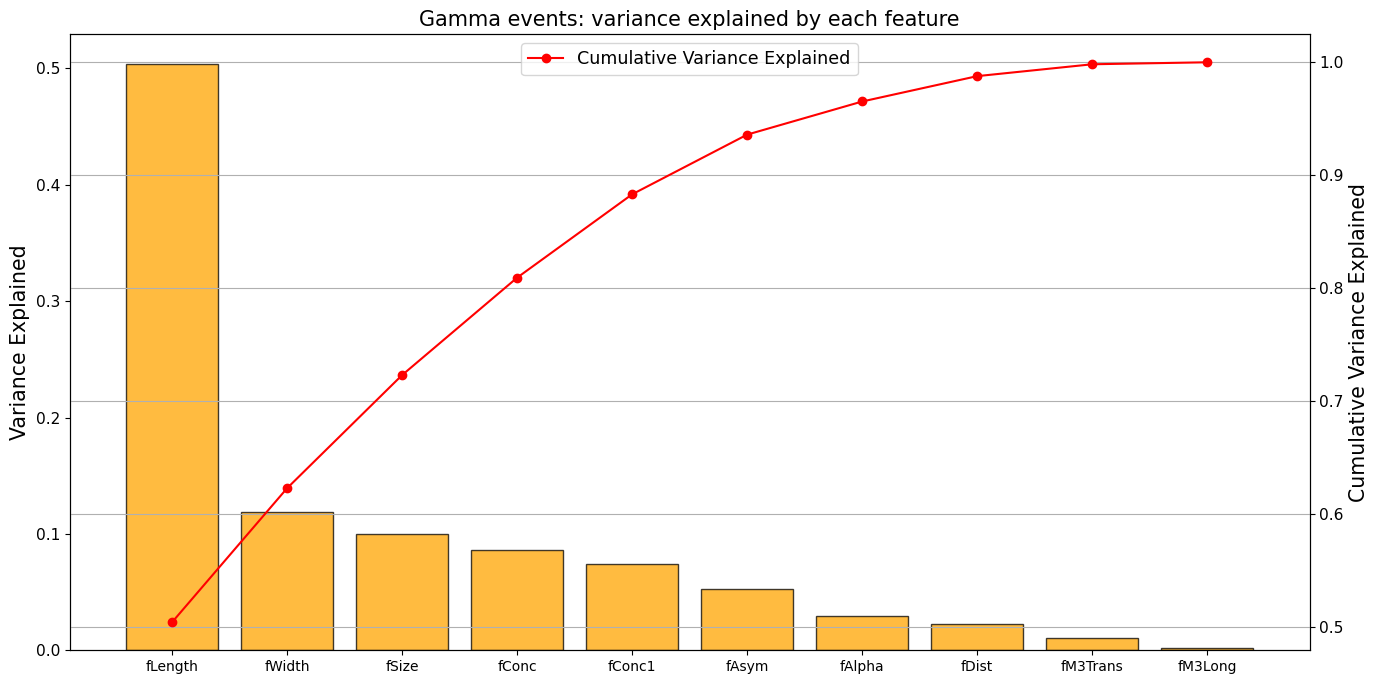

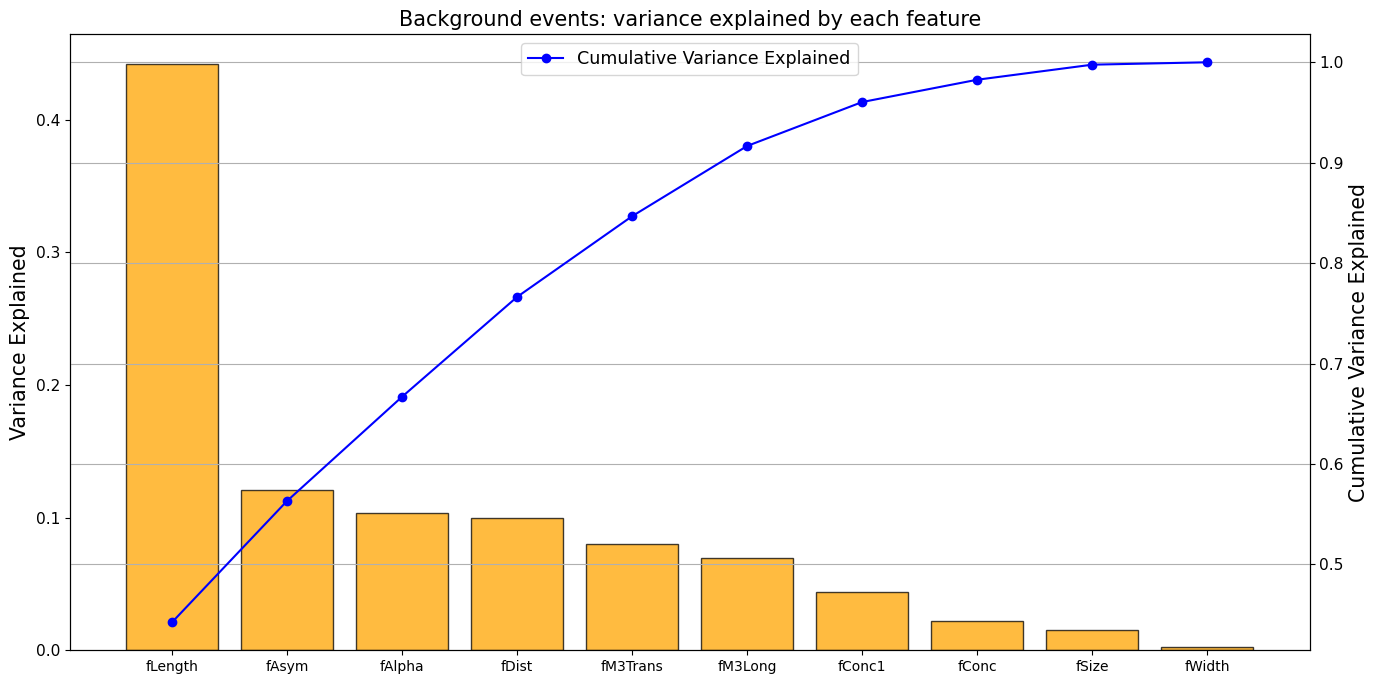

In [25]:
#GAMMA EVENTS
# sort eigenvalues in descending order and get sorted indices
sorted_indices = np.argsort(l_1)[::-1]
l_sorted = l_1[sorted_indices] 
 
variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_1.columns.tolist()

# features ordered from most important to least important to variability 
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # Index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(top_features, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(top_features, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='red')

ax1.set_ylabel('Variance Explained',fontsize='14.7')
ax2.set_ylabel('Cumulative Variance Explained',fontsize='14.7')

plt.title('Gamma events: variance explained by each feature',fontsize='15')
ax2.legend(loc='upper center',fontsize='12.6')

plt.xticks(rotation=45, ha='right', fontsize=14.5)  
ax1.tick_params(axis='y', labelsize=11.1)  
ax2.tick_params(axis='y', labelsize=11.1)  
plt.grid()
plt.show()
print("\n")

#BACKGROUND EVENTS 
sorted_indices = np.argsort(l_0)[::-1]
l_sorted = l_0[sorted_indices] 
 
variance_explained = l_sorted / np.sum(l_sorted) # ratio of the variance of the data explained by each feature

# cumulative variance explained
cumulative_variance = np.cumsum(variance_explained)

feature_names = df_0.columns.tolist()

# features ordered from most important to least important to variability 
top_features = []
for i in range(len(feature_names)):
    most_important_feature_idx = sorted_indices[i]  # Index of the feature with the largest eigenvalue
    top_features.append(feature_names[most_important_feature_idx])

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(top_features, variance_explained, color='Orange', edgecolor='black',alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(top_features, cumulative_variance, label='Cumulative Variance Explained', marker='o', color='blue')

ax1.set_ylabel('Variance Explained',fontsize='14.7')
ax2.set_ylabel('Cumulative Variance Explained',fontsize='14.7')

plt.title('Background events: variance explained by each feature',fontsize='15')
ax2.legend(loc='upper center',fontsize='12.6')

plt.xticks(rotation=45, ha='right', fontsize=14.5)  
ax1.tick_params(axis='y', labelsize=11.1)  
ax2.tick_params(axis='y', labelsize=11.1)  
plt.grid()
plt.show()

We notice that in both cases *fLenght* is the principal component, containing almost 50% of the total varibility of the dataset. There are differencies in the contributions of each feature between gamma and background events, but in both cases the least 4 principal components contribute to less than 5% of the variability. However, we cannot identify which features to disregard since there is not agreement between the two classes. For this reason and also beacuse of the limited number of features of the dataset, we decide to perform the following classification analysis with the complete dataset of features.           

# Part 5: Machine Learning Analysis
In this section we are going to implement several ML algorithms to analyze the data. The objective is to maximize ROC curve area in the range [0-0.2] (false positive rate values), since we mostly want to avoid accpeting hadrons

## Part 5.1: Perceptron
The following code is about Perceptron algorithm. Scikit learn is going to be used. Also, all the analysis is going to be performed without the feature Alpha

First, we associate +1 label to gammas and -1 label to hadrons. Then we split train and test set (20% of total data)

In [26]:
# Alpha has not to be normalized (reset to original value)
X_rescaled['fAlpha'] = original_alpha.copy()

new_Y = []

# gammas are +1    hadrons are -1

for i in range(len(Y)):
    if (Y.iloc[i] == 'g'):
        new_Y.append(1)
    if(Y.iloc[i] == 'h'):
        new_Y.append(-1)
        
Y_df = pd.DataFrame({'category' : new_Y})
data_rescaled_and_indexed = pd.merge(X_rescaled, Y_df,left_index=True, right_index=True)

# divide dataset in 5 parts, taking 1 as test set ( 20 % )
# remove alpha



parts_to_be_split = 5 
train_set, test_set = split_train_test_set( data_rescaled_and_indexed , parts_to_be_split )
train_alpha = train_set['fAlpha']
train_set = train_set.drop('fAlpha',axis=1)
test_alpha = test_set['fAlpha']
test_set = test_set.drop('fAlpha',axis=1)
X_train, Y_train = split_X_Y(train_set)
X_test, Y_test = split_X_Y(test_set)

print('Train set shapes:',np.shape(X_train),np.shape(Y_train))
print('Absolute and relative frequence of points in Training set:')
print(f'Signal: {len(Y_train[Y_train == 1])} points \t {round(len(Y_train[Y_train == 1])/len(Y_train)*100,2)}%')
print(f'Back: {len(Y_train[Y_train == -1])} points \t {round(len(Y_train[Y_train == -1])/len(Y_train)*100,2)}%\n')

print('Test set shapes:',np.shape(X_test),np.shape(Y_test))
print('Absolute and relative frequence of points in Test set:')
print(f'Signal: {len(Y_test[Y_test == 1])} points \t {round(len(Y_test[Y_test == 1])/len(Y_test)*100,2)}%')
print(f'Back: {len(Y_test[Y_test == -1])} points \t {round(len(Y_test[Y_test == -1])/len(Y_test)*100,2)}%\n')


Train set shapes: (15216, 9) (15216,)
Absolute and relative frequence of points in Training set:
Signal: 9873 points 	 64.89%
Back: 5343 points 	 35.11%

Test set shapes: (3803, 9) (3803,)
Absolute and relative frequence of points in Test set:
Signal: 2458 points 	 64.63%
Back: 1345 points 	 35.37%



The following cell performs the training. The parameters are set at the beginning and the best model criterion is the one that maximizes ROC area in range [0-0.2]

In [27]:
n_attempts = 10000
limit = 0.2 
best_scores = []
best_f = []
best_t = []
best_score = 0

#print('n_iter, score')
for i in range (n_attempts):
    state = abs(np.random.normal(size=1))
    state = int(state[0] * 1000000)
    perceptron = Perceptron(alpha=0.01,penalty='l2',max_iter=50000,tol=1e-4,random_state=state,n_iter_no_change=10)
    
    fitted = perceptron.fit(X_train,Y_train)
    
    decision_values = perceptron.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(Y_test, decision_values)
    
    # here i filter data to compute roc curve area for fpr in range 0 -> 0.8
    fpr_filtered = fpr[fpr <= limit]
    tpr_filtered = tpr[:len(fpr_filtered)]
    
    auc_filtered = np.trapz(tpr_filtered, fpr_filtered)
    auc = roc_auc_score(Y_test, decision_values)
    
    # score is better if filtered is better, though saving all 
    if (auc_filtered > best_score):
        best_score = auc_filtered
        best_scores.append(auc)
        best_f.append(fpr)
        best_t.append(tpr)
        best_perceptron = perceptron
        #print(i, auc)

print('Trained',n_attempts,'perceptrons')
print("best AUC-ROC Score:")
print(round(best_scores[len(best_scores)-1],3))

Trained 10000 perceptrons
best AUC-ROC Score:
0.705


Here we plot the confusion matrix for the best model

In [28]:
def normalize_cm(cm):
    norm_cm = np.zeros(shape=(2,2))
    bkg = cm[0,0] + cm[0,1]  # first row is bkg
    sig = cm[1,0] + cm[1,1]  # second row is signal
    norm_cm[0,0] = round(cm[0,0] / bkg,3)
    norm_cm[0,1] = round(cm[0,1] / bkg,3)
    norm_cm[1,0] = round(cm[1,0] / sig,3)
    norm_cm[1,1] = round(cm[1,1] / sig,3)
    
    return norm_cm


def plot_cm(cm,method_name):
    fig = plt.figure()
    im = plt.imshow(cm, cmap='seismic',alpha=0.8, interpolation='nearest')
    plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
    plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = plt.text(j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white")
            text.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground='black')])
            
    fig.tight_layout()
    fig.colorbar(im, location = 'right') 

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.title(f'{method_name} confusion matrix')
    plt.show()

In [29]:
model = best_perceptron
best_perceptron.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

cm = confusion_matrix(Y_test,Y_pred)


Confusion matrix:
[[0.88  0.12 ]
 [0.642 0.358]]


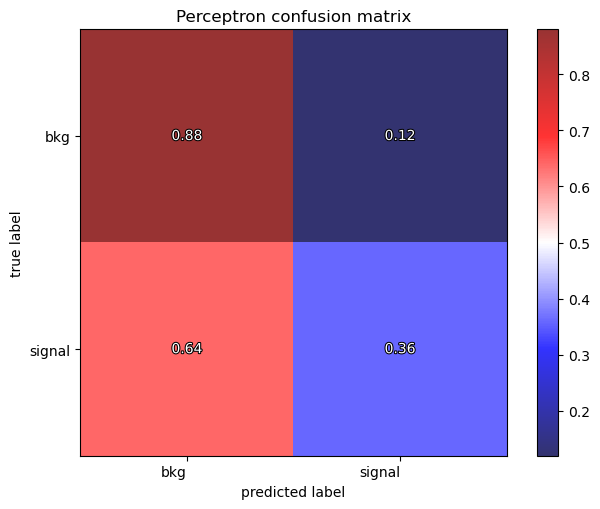

In [30]:
perceptron_cm = normalize_cm(cm)

print('Confusion matrix:')
print(perceptron_cm)
plot_cm(perceptron_cm,method_name='Perceptron')


In the end we take the ROC curve and the best Q value (the one closest to the point (0,1)). We save it in a variable that will be used later as confrontation.

Perceptron Q value: 1.065


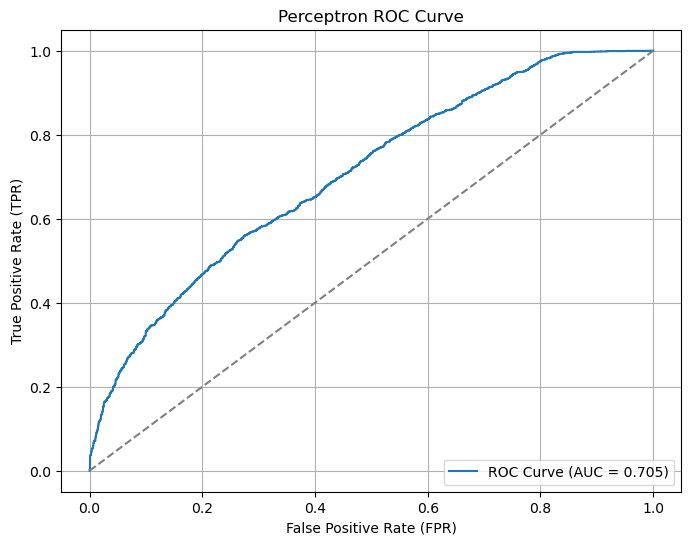

In [31]:
fig = plt.figure(figsize=(8, 6))

fpr_perceptron = best_f[len(best_f)-1] 
tpr_perceptron = best_t[len(best_f)-1]
Q_perceptron = get_best_Q(fpr_perceptron,tpr_perceptron)

print('Perceptron Q value:',round(Q_perceptron,3))
plt.plot(fpr_perceptron, tpr_perceptron, label=f'ROC Curve (AUC = {best_scores[len(best_f)-1]:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('Perceptron ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

## Part 5.2: SVM
In this part the same dataset is analyzed with soft SVM. Different kernels are tried (linear,poly with deg 3,rbf and sigmoid), as well as different values for parameters such as nu and gamma

In [32]:
alphaCol = data_rescaled_and_indexed['fAlpha'] 
data_rescaled_and_indexed = data_rescaled_and_indexed.drop('fAlpha',axis = 1)
print(np.shape(data_rescaled_and_indexed))

(19019, 10)


In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.svm import NuSVC
from sklearn.model_selection import KFold
from time import time

# list with all possible kernels (poly uses deg = 3 as standard value)
kernels = ['linear','poly','rbf','sigmoid']


# list with all nu values (upper bound on fraction of margin errors)
nus = [ 0.5 , 0.1 , 0.05 , 0.01 ]

# list with all gamma values (by default is 1/(n_features*X.var()) )
gammas = [ 0.1, 0.01, 0.001, 0.0001 ]

best_auc_score = 0

# tolerance for stopping criteria (default is 1e-3) (default max_iter is inf)
tolerance = 1e-6
max_iter = int(2e4)

# K fold definition
K = 5
limit = 0.2 
kf = KFold(n_splits=K, shuffle=True, random_state=42) 
kFoldInfo = 0

start_time = time()


for kernel_type in kernels:
    for nu in nus:
        for gamma in gammas:
            print(f'training SVM with {kernel_type} kernel...')
            partial_auc = 0
            auc_value = 0
            for train_idx, val_idx in kf.split(data_rescaled_and_indexed):  ###gets the index of training and validation set
                
                train_K=data_rescaled_and_indexed.iloc[train_idx]
                valid_K=data_rescaled_and_indexed.iloc[val_idx]
                X_train_K, Y_train_K = split_X_Y(train_K)
                X_valid_K, Y_valid_K = split_X_Y(valid_K)
                
                if kFoldInfo == 0:
                    print("Train fold size:",np.shape(X_train_K),"\t Test fold size:",np.shape(X_valid_K))
                    KFoldInfo = 1
                
                clf = make_pipeline(StandardScaler(), NuSVC(nu=nu,kernel=kernel_type,gamma=gamma,probability=True,tol=tolerance,max_iter=max_iter),verbose=False)
    
                fitted = clf.fit(X_train_K, Y_train_K)
                pred = clf.predict(X_valid_K)
                errors = np.sum(pred != Y_valid_K) / len(Y_valid_K)
                
                pred_prob = clf.predict_proba(X_valid_K)[:, 1]
                fpr, tpr, thresholds = roc_curve(Y_valid_K, pred_prob)
                
                auc_value_k = auc(fpr, tpr)
                fpr_filtered = fpr[fpr <= limit]

                if (len(fpr_filtered) < 2 ):
                    partial_auc=0
                else:
                    tpr_filtered = tpr[:len(fpr_filtered)]
                    partial_auc_k = np.trapz(fpr_filtered, tpr_filtered)
                partial_auc += partial_auc_k/K
                auc_value += auc_value_k/K                 
            if(partial_auc > best_auc_score):
                best_auc_score = partial_auc
                best_model = clf
                best_tpr = tpr
                best_fpr = fpr
                best_auc = auc_value
                best_kernel = kernel_type
                best_nu = nu
                best_gamma = gamma
                print(partial_auc.round(3),best_auc.round(3), kernel_type, nu, gamma)
            print('elapsed time:',round(time()-start_time,3))
            start_time = time()

print('best results are for')
print('kernel:',best_kernel,'nu:',best_nu,'gamma:',best_gamma,'with auc:',best_auc)


training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.027 0.56 linear 0.5 0.1
elapsed time: 124.536
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 126.553
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 126.09
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 123.023
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 51.362
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 51.341
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 51.351
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 51.343
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 43.384
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.028 0.601 linear 0.05 0.01
elapsed time: 44.547
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 44.366
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 43.732
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 35.641
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 36.213
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 35.562
training SVM with linear kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 35.908
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.054 0.793 poly 0.5 0.1
elapsed time: 156.68
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.055 0.793 poly 0.5 0.01
elapsed time: 157.38
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 122.394
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 75.27
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 56.53
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 57.175
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 19.34
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 14.057
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 45.438
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 45.699
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 10.63
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 6.994
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 38.215
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 36.914
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 3.117
training SVM with poly kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 1.528
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
0.058 0.843 rbf 0.5 0.1
elapsed time: 193.898
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 204.578
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 222.337
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 222.111
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 97.518
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 82.589
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 77.141
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 82.334
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 84.013
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 66.832
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 60.543
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 65.9
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 74.503
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 53.894
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 47.369
training SVM with rbf kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 47.654
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 299.743
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 265.654
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 215.558
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 199.098
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 78.174
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 71.243
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 85.376
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 37.913
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 39.427
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 36.333
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 58.223
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 21.361
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 9.057
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 8.102
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15215, 9) 	 Test fold size: (3804, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train fold size: (15216, 9) 	 Test fold size: (3803, 9)


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 32.623
training SVM with sigmoid kernel...
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15215, 9) 	 Test fold size: (3804, 9)
Train fold size: (15216, 9) 	 Test fold size: (3803, 9)
elapsed time: 3.413
best results are for
kernel: rbf nu: 0.5 gamma: 0.1 with auc: 0.8425728017585027


Here we have the confusion matrix

Confusion matrix:
[[0.503 0.497]
 [0.035 0.965]]


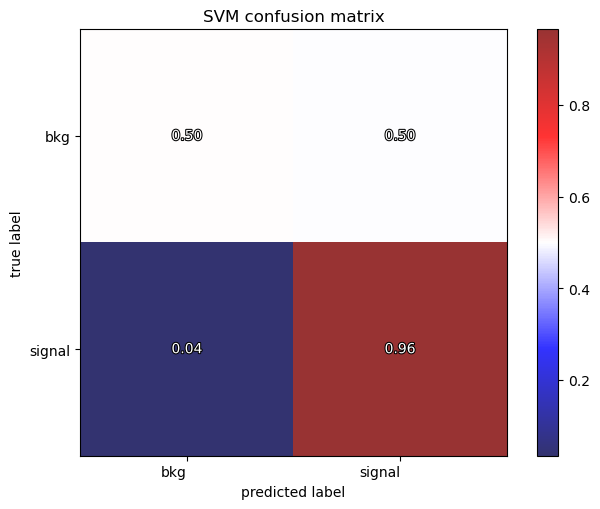

In [34]:
best_pred = best_model.predict(X_test)
cm = confusion_matrix(Y_test,best_pred)
SVM_cm = normalize_cm(cm)

print('Confusion matrix:')
print(SVM_cm)
plot_cm(SVM_cm,method_name='SVM')


The best curve is then plotted and saved

best SVM Q value: 1.683217391850784


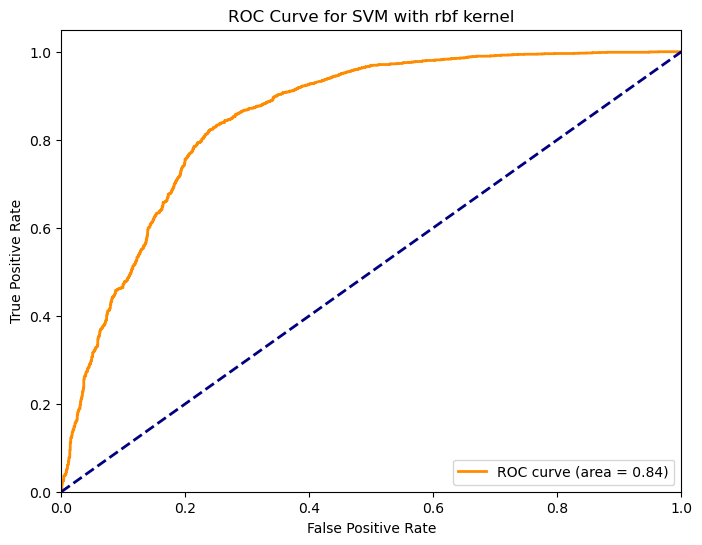

In [35]:
tpr_SVM = best_tpr
fpr_SVM = best_fpr
Q_SVM = get_best_Q(fpr_SVM,tpr_SVM)

print('best SVM Q value:',Q_SVM)
plt.figure(figsize=(8, 6))
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

Let's check how SVM performed in comparison to Perceptron

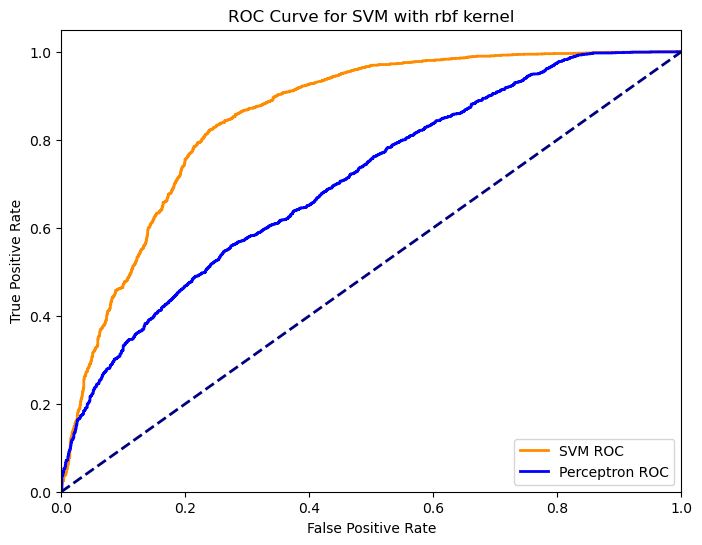

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM, tpr_SVM, color='darkorange', lw=2, label='SVM ROC' % best_auc)
plt.plot(fpr_perceptron, tpr_perceptron, color='blue', lw=2, label='Perceptron ROC' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

## Part 5.3: Random Forest
Here we are going to implement a Random Forest classification algorithm. A Random Forest is composed of different decision tree predictors. For each tree, at each iteration, the data are split into two branches according to a threshold value for one of the features. At each split, the best feature and the best threshold value are chosen by minimizing the entropy function 
𝐻 given by:
$$
\displaystyle H = - \sum_{i=+1,-1} f_i \log_2(f_i)
$$
where $f_i$ is the fraction of points of class $i=+1,-1$ in the training set. The splitting continues until either a maximum depth for the tree is reached, in which case the most frequent class of the branch is assigned to all points, or the points of the branch all belong to the same class (in this case the branch is called a leaf). Different trees are built by randomly drawing data with replacement from the test set, applying the algorithm to each tree. The final label for a point is chosen based on a majority vote of the trees results. 

The hyper-parameters of the model are the **number of trees** and the **maximum depth** of the trees. We are going to implement a K-fold cross validation to choose as best hyper-parameters the ones that maximize the area under the ROC curve of the classifier. To build the ROC curve we need to estimate the probability for the points to belong to a certain class. This can be done because each tree, at the last decision step, assigns a class label based on the majority class of the training samples that reached that final leaf node, but also keeps track of the proportion of the classes in that leaf node. For example, suppose a test point ends up in a leaf node where, out of 100 training samples that ended up there, 80 belonged to class 1 and 20 belonged to class -1. The probability of the point belonging to class 1 would be 0.8, while the probability of it belonging to class -1 would be 0.2.\

We will use the class `RandomForestClassifier` from `scikit-learn` to implement and train the Forest and to predict the labels with their probabilities.   


\
**DA METTERE QUANDO SI INTRODUCE IL CONCETTO DI ROC CURVE?**
The ROC curve plots the True Positive Rate (TPR), i.e: the fraction of actual gamma samples correctly identified as gamma, versus the False Positive Rate, i.e: the fraction of actual hadrons incorrectly classified as gamma by the model. To do so, it's necessary to estimate a probability for the predicted class, not just to assign the predicted label. Imposing different threshold values on the probability for the acceptance of an event as either gamma or hadron, we can obtain the ROC curve.   \
\


In [51]:
from time import time

num_trees= np.arange(40,300,10)
max_depth= np.arange(10,40,2)
accuracies=[]
roc_areas=[]
best_area=0
best_acc=0
best_model= [] # stores best number of trees and best max depth
partial_aucs = []

start_time = time()

max_iter = len(num_trees) * len(max_depth)
iteration = 0

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

for tree in num_trees:
    for depth in max_depth:
        ############accuracies?
        partial_auc = 0
        auc_value = 0
        accuracy = 0
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            print(f"  Fold n. {i}")
            train_K=data_rescaled_and_indexed.iloc[train_idx]
            valid_K = data_rescaled_and_indexed.iloc[test_index]

            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            forest = RandomForestClassifier(n_estimators=tree,  # number of trees
                                           max_depth= depth, 
                                           max_features=X_train.shape[1],   # number of features for each split (random subset)
                                           bootstrap=True,    # bagging (sampling with replacement)
                                           max_samples=1.0,   # percentage of samples to use for each tree (100% of data)
                                           random_state=10,
                                           n_jobs=-1)
            # train each model, predict labels and probability of each label
            forest.fit(X_train_K, Y_train_K)
            Y_pred = forest.predict(X_valid_K)
            y_pred_prob = forest.predict_proba(X_valid_K)[:, 1] # probability for the validation points to belong to class +1 or -1
            # accuracy on validation set
            accuracy_k = accuracy_score(Y_valid_K, Y_pred)
            iteration +=1 
            print(f'elapsed time: {round(time()-start_time,2)}s, done {iteration} out of {max_iter*K}')
            print('Number of trees:',tree,', Maximum depth',depth,':') 
            print('Accuracy:',accuracy_k)
            # false positive rates and the true positive rates for different threshold values 
            fpr, tpr, thresholds = roc_curve(Y_valid_K, y_pred_prob)

            # area under the ROC curve on validation set 
            roc_auc_k = auc(fpr, tpr)
            roc_areas.append(roc_auc_k)
            '''if(roc_auc>best_area):
                best_area= roc_auc
                best_acc= accuracy
                best_model=[tree,depth]
                '''
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc = 0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += roc_auc_k/K
        
        partial_aucs.append(partial_auc)
        if(partial_auc>best_area):
            best_area= partial_auc
            best_total_auc = auc_value
            best_acc= accuracy
            best_model=[tree,depth]
        print('\033[91mArea under ROC curve:',round(auc_value,3),'Selected area:',round(partial_auc,3),'\033[0m')
        print('\n')
        
print('Best number of trees:', best_model[0],'\n')
print('Best maximum depth:', best_model[1],'\n')
print('Area under ROC curve of best model:',best_area)

  Fold n. 0
elapsed time: 0.97s, done 1 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8554153522607781
  Fold n. 1
elapsed time: 1.89s, done 2 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8509463722397477
  Fold n. 2
elapsed time: 2.82s, done 3 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.861198738170347
  Fold n. 3
elapsed time: 3.82s, done 4 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8470031545741324
  Fold n. 4
elapsed time: 4.74s, done 5 out of 1950
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8146200368130423
Area under ROC curve: 0.894 Selected area: 0.111 


  Fold n. 0
elapsed time: 5.84s, done 6 out of 1950
Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8824921135646687
  Fold n. 1
elapsed time: 6.96s, done 7 out of 1950
Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8777602523659306
  Fold n. 2
elapsed time: 8.09s, done 8 out of 1950
Number of trees: 40 , Maximum depth 12 :
Ac

elapsed time: 107.02s, done 62 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.9994742376445847
  Fold n. 2
elapsed time: 109.19s, done 63 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 111.38s, done 64 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 113.68s, done 65 out of 1950
Number of trees: 40 , Maximum depth 34 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.976 Selected area: 0.166 


  Fold n. 0
elapsed time: 115.84s, done 66 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9994742376445847
  Fold n. 1
elapsed time: 118.0s, done 67 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9994742376445847
  Fold n. 2
elapsed time: 120.27s, done 68 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 122.43s, done 69 out of 1950
Number of trees: 40 , Maximum depth 36 :
Accur

elapsed time: 242.97s, done 122 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9926393270241851
  Fold n. 2
elapsed time: 245.86s, done 123 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 3
elapsed time: 248.59s, done 124 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.9957939011566772
  Fold n. 4
elapsed time: 251.27s, done 125 out of 1950
Number of trees: 50 , Maximum depth 28 :
Accuracy: 0.8409150670523271
Area under ROC curve: 0.976 Selected area: 0.177 


  Fold n. 0
elapsed time: 253.94s, done 126 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9971083070452156
  Fold n. 1
elapsed time: 256.68s, done 127 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9965825446898002
  Fold n. 2
elapsed time: 259.37s, done 128 out of 1950
Number of trees: 50 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 3
elapsed time: 262.07s, done 129 out of 1950
Number of trees: 50 , 

elapsed time: 399.66s, done 182 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9713459516298633
  Fold n. 2
elapsed time: 402.6s, done 183 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9742376445846478
  Fold n. 3
elapsed time: 405.57s, done 184 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.9687171398527865
  Fold n. 4
elapsed time: 408.58s, done 185 out of 1950
Number of trees: 60 , Maximum depth 22 :
Accuracy: 0.834341309492506
Area under ROC curve: 0.975 Selected area: 0.166 


  Fold n. 0
elapsed time: 411.65s, done 186 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.9810725552050473
  Fold n. 1
elapsed time: 414.77s, done 187 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.981335436382755
  Fold n. 2
elapsed time: 417.81s, done 188 out of 1950
Number of trees: 60 , Maximum depth 24 :
Accuracy: 0.9852786540483701
  Fold n. 3
elapsed time: 420.91s, done 189 out of 1950
Number of trees: 60 , Max

elapsed time: 578.89s, done 242 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.9282334384858044
  Fold n. 2
elapsed time: 581.83s, done 243 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.9295478443743428
  Fold n. 3
elapsed time: 584.91s, done 244 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.92534174553102
  Fold n. 4
elapsed time: 587.91s, done 245 out of 1950
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.959 Selected area: 0.157 


  Fold n. 0
elapsed time: 591.05s, done 246 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9413774973711883
  Fold n. 1
elapsed time: 594.22s, done 247 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9463722397476341
  Fold n. 2
elapsed time: 597.35s, done 248 out of 1950
Number of trees: 70 , Maximum depth 18 :
Accuracy: 0.9471608832807571
  Fold n. 3
elapsed time: 600.47s, done 249 out of 1950
Number of trees: 70 , Ma

elapsed time: 790.72s, done 303 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8638275499474237
  Fold n. 3
elapsed time: 793.24s, done 304 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8480546792849631
  Fold n. 4
elapsed time: 795.75s, done 305 out of 1950
Number of trees: 80 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.896 Selected area: 0.113 


  Fold n. 0
elapsed time: 798.51s, done 306 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8830178759200841
  Fold n. 1
elapsed time: 801.29s, done 307 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8780231335436383
  Fold n. 2
elapsed time: 804.17s, done 308 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.8851209253417456
  Fold n. 3
elapsed time: 806.95s, done 309 out of 1950
Number of trees: 80 , Maximum depth 12 :
Accuracy: 0.880651945320715
  Fold n. 4
elapsed time: 809.78s, done 310 out of 1950
Number of trees: 80 , M

elapsed time: 1012.13s, done 363 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 0.9997371188222923
  Fold n. 3
elapsed time: 1016.33s, done 364 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 1020.43s, done 365 out of 1950
Number of trees: 80 , Maximum depth 34 :
Accuracy: 0.8388114646331843
Area under ROC curve: 0.976 Selected area: 0.172 


  Fold n. 0
elapsed time: 1024.51s, done 366 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 1028.61s, done 367 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 1032.71s, done 368 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 1036.83s, done 369 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 1040.88s, done 370 out of 1950
Number of trees: 80 , Maximum depth 36 :
Accuracy: 0.837759663423613
Area under ROC curve

elapsed time: 1249.64s, done 423 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.9973711882229233
  Fold n. 3
elapsed time: 1254.33s, done 424 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 4
elapsed time: 1258.97s, done 425 out of 1950
Number of trees: 90 , Maximum depth 28 :
Accuracy: 0.8374967131212201
Area under ROC curve: 0.976 Selected area: 0.177 


  Fold n. 0
elapsed time: 1263.55s, done 426 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9981598317560463
  Fold n. 1
elapsed time: 1268.22s, done 427 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9973711882229233
  Fold n. 2
elapsed time: 1272.82s, done 428 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9989484752891693
  Fold n. 3
elapsed time: 1277.4s, done 429 out of 1950
Number of trees: 90 , Maximum depth 30 :
Accuracy: 0.9994742376445847
  Fold n. 4
elapsed time: 1282.08s, done 430 out of 1950
Number of trees

elapsed time: 1508.01s, done 483 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.9752891692954785
  Fold n. 3
elapsed time: 1512.78s, done 484 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.9716088328075709
  Fold n. 4
elapsed time: 1517.54s, done 485 out of 1950
Number of trees: 100 , Maximum depth 22 :
Accuracy: 0.8351301603996845
Area under ROC curve: 0.975 Selected area: 0.175 


  Fold n. 0
elapsed time: 1522.44s, done 486 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.980546792849632
  Fold n. 1
elapsed time: 1527.35s, done 487 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 2
elapsed time: 1532.24s, done 488 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.9858044164037855
  Fold n. 3
elapsed time: 1537.21s, done 489 out of 1950
Number of trees: 100 , Maximum depth 24 :
Accuracy: 0.9808096740273397
  Fold n. 4
elapsed time: 1542.1s, done 490 out of 1950
Number of 

elapsed time: 1791.74s, done 543 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.9303364879074658
  Fold n. 3
elapsed time: 1796.19s, done 544 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.9277076761303891
  Fold n. 4
elapsed time: 1800.7s, done 545 out of 1950
Number of trees: 110 , Maximum depth 16 :
Accuracy: 0.8319747567709703
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 1805.52s, done 546 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9421661409043113
  Fold n. 1
elapsed time: 1810.32s, done 547 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.944006309148265
  Fold n. 2
elapsed time: 1815.3s, done 548 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9476866456361724
  Fold n. 3
elapsed time: 1820.18s, done 549 out of 1950
Number of trees: 110 , Maximum depth 18 :
Accuracy: 0.9450578338590957
  Fold n. 4
elapsed time: 1824.98s, done 550 out of 1950
Number of t

elapsed time: 2110.34s, done 603 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8640904311251314
  Fold n. 3
elapsed time: 2113.88s, done 604 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8483175604626709
  Fold n. 4
elapsed time: 2117.55s, done 605 out of 1950
Number of trees: 120 , Maximum depth 10 :
Accuracy: 0.8193531422561136
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 2121.62s, done 606 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8835436382754994
  Fold n. 1
elapsed time: 2125.74s, done 607 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8774973711882229
  Fold n. 2
elapsed time: 2129.78s, done 608 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8856466876971609
  Fold n. 3
elapsed time: 2133.84s, done 609 out of 1950
Number of trees: 120 , Maximum depth 12 :
Accuracy: 0.8796004206098843
  Fold n. 4
elapsed time: 2137.91s, done 610 out of 1950
Number 

elapsed time: 2429.0s, done 662 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 0.9997371188222923
  Fold n. 2
elapsed time: 2435.02s, done 663 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 2441.36s, done 664 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 2447.42s, done 665 out of 1950
Number of trees: 120 , Maximum depth 34 :
Accuracy: 0.8372337628188272
Area under ROC curve: 0.976 Selected area: 0.178 


  Fold n. 0
elapsed time: 2453.67s, done 666 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 2459.75s, done 667 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 2465.79s, done 668 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 2472.06s, done 669 out of 1950
Number of trees: 120 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 2

elapsed time: 2770.4s, done 722 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9931650893796005
  Fold n. 2
elapsed time: 2776.9s, done 723 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9973711882229233
  Fold n. 3
elapsed time: 2783.4s, done 724 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.9976340694006309
  Fold n. 4
elapsed time: 2789.94s, done 725 out of 1950
Number of trees: 130 , Maximum depth 28 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 2796.51s, done 726 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 1
elapsed time: 2803.12s, done 727 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 2809.69s, done 728 out of 1950
Number of trees: 130 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 2816.25s, done 729 out of 1950
Number of t

elapsed time: 3137.08s, done 783 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.9758149316508938
  Fold n. 3
elapsed time: 3143.68s, done 784 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.9710830704521556
  Fold n. 4
elapsed time: 3150.2s, done 785 out of 1950
Number of trees: 140 , Maximum depth 22 :
Accuracy: 0.834341309492506
Area under ROC curve: 0.976 Selected area: 0.116 


  Fold n. 0
elapsed time: 3157.25s, done 786 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 1
elapsed time: 3164.08s, done 787 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9818611987381703
  Fold n. 2
elapsed time: 3170.83s, done 788 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9868559411146162
  Fold n. 3
elapsed time: 3177.57s, done 789 out of 1950
Number of trees: 140 , Maximum depth 24 :
Accuracy: 0.9789695057833859
  Fold n. 4
elapsed time: 3184.39s, done 790 out of 1950
Number of 

elapsed time: 3529.86s, done 844 out of 1950
Number of trees: 150 , Maximum depth 16 :
Accuracy: 0.9274447949526814
  Fold n. 4
elapsed time: 3535.86s, done 845 out of 1950
Number of trees: 150 , Maximum depth 16 :
Accuracy: 0.8311859058637917
Area under ROC curve: 0.96 Selected area: 0.157 


  Fold n. 0
elapsed time: 3542.31s, done 846 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9426919032597266
  Fold n. 1
elapsed time: 3548.85s, done 847 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 3555.33s, done 848 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.9474237644584648
  Fold n. 3
elapsed time: 3561.72s, done 849 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.944794952681388
  Fold n. 4
elapsed time: 3568.16s, done 850 out of 1950
Number of trees: 150 , Maximum depth 18 :
Accuracy: 0.8332895082829346
Area under ROC curve: 0.969 Selected area: 0.132 


  Fold n. 0
el

elapsed time: 3960.45s, done 905 out of 1950
Number of trees: 160 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.898 Selected area: 0.114 


  Fold n. 0
elapsed time: 3965.8s, done 906 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8838065194532071
  Fold n. 1
elapsed time: 3971.28s, done 907 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8793375394321766
  Fold n. 2
elapsed time: 3976.58s, done 908 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8859095688748686
  Fold n. 3
elapsed time: 3982.06s, done 909 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 4
elapsed time: 3987.36s, done 910 out of 1950
Number of trees: 160 , Maximum depth 12 :
Accuracy: 0.8246121483039706
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n. 0
elapsed time: 3993.21s, done 911 out of 1950
Number of trees: 160 , Maximum depth 14 :
Accuracy: 0.9045741324921136
  Fold n. 1
e

elapsed time: 4394.64s, done 965 out of 1950
Number of trees: 160 , Maximum depth 34 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 4402.87s, done 966 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 4410.84s, done 967 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 4418.83s, done 968 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 4426.81s, done 969 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 4434.76s, done 970 out of 1950
Number of trees: 160 , Maximum depth 36 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 4442.73s, done 971 out of 1950
Number of trees: 160 , Maximum depth 38 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 4450.7s, done 972 out of 1950
Number of trees: 160 , Maximum dep

elapsed time: 4835.67s, done 1025 out of 1950
Number of trees: 170 , Maximum depth 28 :
Accuracy: 0.8380226137260058
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 4844.25s, done 1026 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9986855941114616
  Fold n. 1
elapsed time: 4852.73s, done 1027 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9978969505783386
  Fold n. 2
elapsed time: 4861.2s, done 1028 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9994742376445847
  Fold n. 3
elapsed time: 4869.71s, done 1029 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.9997371188222923
  Fold n. 4
elapsed time: 4878.22s, done 1030 out of 1950
Number of trees: 170 , Maximum depth 30 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 4886.74s, done 1031 out of 1950
Number of trees: 170 , Maximum depth 32 :
Accuracy: 1.0
  Fold n. 1
elapsed tim

elapsed time: 5301.23s, done 1085 out of 1950
Number of trees: 180 , Maximum depth 22 :
Accuracy: 0.8372337628188272
Area under ROC curve: 0.976 Selected area: 0.105 


  Fold n. 0
elapsed time: 5309.9s, done 1086 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9818611987381703
  Fold n. 1
elapsed time: 5318.5s, done 1087 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.982124079915878
  Fold n. 2
elapsed time: 5327.18s, done 1088 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9860672975814931
  Fold n. 3
elapsed time: 5335.75s, done 1089 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.9802839116719243
  Fold n. 4
elapsed time: 5344.34s, done 1090 out of 1950
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.976 Selected area: 0.153 


  Fold n. 0
elapsed time: 5353.16s, done 1091 out of 1950
Number of trees: 180 , Maximum depth 26 :
Accuracy: 0.9897476340694006
  Fold n.

elapsed time: 5802.62s, done 1145 out of 1950
Number of trees: 190 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 5810.92s, done 1146 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.9421661409043113
  Fold n. 1
elapsed time: 5818.93s, done 1147 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.944794952681388
  Fold n. 2
elapsed time: 5827.38s, done 1148 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.9468980021030494
  Fold n. 3
elapsed time: 5835.55s, done 1149 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.944006309148265
  Fold n. 4
elapsed time: 5843.62s, done 1150 out of 1950
Number of trees: 190 , Maximum depth 18 :
Accuracy: 0.8348672100972916
Area under ROC curve: 0.969 Selected area: 0.13 


  Fold n. 0
elapsed time: 5852.13s, done 1151 out of 1950
Number of trees: 190 , Maximum depth 20 :
Accuracy: 0.9568874868559412
  Fold n.

elapsed time: 6336.07s, done 1205 out of 1950
Number of trees: 200 , Maximum depth 10 :
Accuracy: 0.8180383907441493
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 6342.61s, done 1206 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8840694006309149
  Fold n. 1
elapsed time: 6349.27s, done 1207 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 6356.03s, done 1208 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8874868559411146
  Fold n. 3
elapsed time: 6362.78s, done 1209 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.879863301787592
  Fold n. 4
elapsed time: 6369.48s, done 1210 out of 1950
Number of trees: 200 , Maximum depth 12 :
Accuracy: 0.8275046016302918
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n. 0
elapsed time: 6376.83s, done 1211 out of 1950
Number of trees: 200 , Maximum depth 14 :
Accuracy: 0.9056256572029443
  Fold

elapsed time: 6867.8s, done 1264 out of 1950
Number of trees: 200 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 6877.7s, done 1265 out of 1950
Number of trees: 200 , Maximum depth 34 :
Accuracy: 0.83933736523797
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 6887.8s, done 1266 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 6897.69s, done 1267 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 6907.56s, done 1268 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 6917.53s, done 1269 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 6927.44s, done 1270 out of 1950
Number of trees: 200 , Maximum depth 36 :
Accuracy: 0.8403891664475415
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 6937.35s, done 1271 out of 1950
Number of trees: 200 , Maximu

elapsed time: 7411.36s, done 1324 out of 1950
Number of trees: 210 , Maximum depth 28 :
Accuracy: 0.9971083070452156
  Fold n. 4
elapsed time: 7421.72s, done 1325 out of 1950
Number of trees: 210 , Maximum depth 28 :
Accuracy: 0.8406521167499342
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 7432.15s, done 1326 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 7442.55s, done 1327 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 7452.94s, done 1328 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 7463.32s, done 1329 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.9997371188222923
  Fold n. 4
elapsed time: 7474.05s, done 1330 out of 1950
Number of trees: 210 , Maximum depth 30 :
Accuracy: 0.8388114646331843
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n

elapsed time: 7975.3s, done 1384 out of 1950
Number of trees: 220 , Maximum depth 22 :
Accuracy: 0.9726603575184016
  Fold n. 4
elapsed time: 7985.57s, done 1385 out of 1950
Number of trees: 220 , Maximum depth 22 :
Accuracy: 0.837759663423613
Area under ROC curve: 0.976 Selected area: 0.073 


  Fold n. 0
elapsed time: 7996.07s, done 1386 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.981335436382755
  Fold n. 1
elapsed time: 8006.86s, done 1387 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.9823869610935857
  Fold n. 2
elapsed time: 8017.32s, done 1388 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.9860672975814931
  Fold n. 3
elapsed time: 8027.81s, done 1389 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.980546792849632
  Fold n. 4
elapsed time: 8038.26s, done 1390 out of 1950
Number of trees: 220 , Maximum depth 24 :
Accuracy: 0.8380226137260058
Area under ROC curve: 0.976 Selected area: 0.16 


  Fold n. 

elapsed time: 8568.84s, done 1444 out of 1950
Number of trees: 230 , Maximum depth 16 :
Accuracy: 0.9290220820189274
  Fold n. 4
elapsed time: 8577.99s, done 1445 out of 1950
Number of trees: 230 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.153 


  Fold n. 0
elapsed time: 8588.07s, done 1446 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9426919032597266
  Fold n. 1
elapsed time: 8597.99s, done 1447 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 8607.67s, done 1448 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9484752891692955
  Fold n. 3
elapsed time: 8617.34s, done 1449 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.9442691903259727
  Fold n. 4
elapsed time: 8627.04s, done 1450 out of 1950
Number of trees: 230 , Maximum depth 18 :
Accuracy: 0.8367078622140416
Area under ROC curve: 0.969 Selected area: 0.133 


  Fold

elapsed time: 9214.1s, done 1504 out of 1950
Number of trees: 240 , Maximum depth 10 :
Accuracy: 0.8477917981072555
  Fold n. 4
elapsed time: 9221.05s, done 1505 out of 1950
Number of trees: 240 , Maximum depth 10 :
Accuracy: 0.8183013410465422
Area under ROC curve: 0.898 Selected area: 0.113 


  Fold n. 0
elapsed time: 9228.97s, done 1506 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8819663512092534
  Fold n. 1
elapsed time: 9236.83s, done 1507 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 9245.01s, done 1508 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8856466876971609
  Fold n. 3
elapsed time: 9253.17s, done 1509 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.880651945320715
  Fold n. 4
elapsed time: 9261.3s, done 1510 out of 1950
Number of trees: 240 , Maximum depth 12 :
Accuracy: 0.8288193531422561
Area under ROC curve: 0.925 Selected area: 0.133 


  Fold n

elapsed time: 9841.82s, done 1563 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 9853.61s, done 1564 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 9865.45s, done 1565 out of 1950
Number of trees: 240 , Maximum depth 34 :
Accuracy: 0.8396003155403629
Area under ROC curve: 0.977 Selected area: 0.18 


  Fold n. 0
elapsed time: 9877.79s, done 1566 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 9889.72s, done 1567 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 9901.51s, done 1568 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 9913.36s, done 1569 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 9925.21s, done 1570 out of 1950
Number of trees: 240 , Maximum depth 36 :
Accuracy: 0.8388114646331843
Area under ROC curv

elapsed time: 10469.3s, done 1622 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9939537329127235
  Fold n. 2
elapsed time: 10481.57s, done 1623 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9978969505783386
  Fold n. 3
elapsed time: 10493.83s, done 1624 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.9976340694006309
  Fold n. 4
elapsed time: 10506.05s, done 1625 out of 1950
Number of trees: 250 , Maximum depth 28 :
Accuracy: 0.8403891664475415
Area under ROC curve: 0.977 Selected area: 0.178 


  Fold n. 0
elapsed time: 10518.39s, done 1626 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 10530.66s, done 1627 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.9978969505783386
  Fold n. 2
elapsed time: 10542.95s, done 1628 out of 1950
Number of trees: 250 , Maximum depth 30 :
Accuracy: 0.999211356466877
  Fold n. 3
elapsed time: 10555.34s, done 1629 out of

elapsed time: 11134.7s, done 1682 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9721345951629863
  Fold n. 2
elapsed time: 11146.69s, done 1683 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9752891692954785
  Fold n. 3
elapsed time: 11158.64s, done 1684 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.9718717139852786
  Fold n. 4
elapsed time: 11170.62s, done 1685 out of 1950
Number of trees: 260 , Maximum depth 22 :
Accuracy: 0.8385485143307915
Area under ROC curve: 0.976 Selected area: 0.1 


  Fold n. 0
elapsed time: 11182.92s, done 1686 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9810725552050473
  Fold n. 1
elapsed time: 11195.23s, done 1687 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9823869610935857
  Fold n. 2
elapsed time: 11207.66s, done 1688 out of 1950
Number of trees: 260 , Maximum depth 24 :
Accuracy: 0.9858044164037855
  Fold n. 3
elapsed time: 11219.97s, done 1689 out of

elapsed time: 11837.17s, done 1742 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9303364879074658
  Fold n. 2
elapsed time: 11848.02s, done 1743 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9300736067297581
  Fold n. 3
elapsed time: 11858.72s, done 1744 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.9282334384858044
  Fold n. 4
elapsed time: 11869.36s, done 1745 out of 1950
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.8338154088877202
Area under ROC curve: 0.96 Selected area: 0.155 


  Fold n. 0
elapsed time: 11880.72s, done 1746 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9419032597266036
  Fold n. 1
elapsed time: 11892.03s, done 1747 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9453207150368034
  Fold n. 2
elapsed time: 11903.37s, done 1748 out of 1950
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.9471608832807571
  Fold n. 3
elapsed time: 11914.69s, done 1749 out 

elapsed time: 12594.21s, done 1802 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8543638275499474
  Fold n. 2
elapsed time: 12602.47s, done 1803 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8638275499474237
  Fold n. 3
elapsed time: 12610.55s, done 1804 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8480546792849631
  Fold n. 4
elapsed time: 12618.57s, done 1805 out of 1950
Number of trees: 280 , Maximum depth 10 :
Accuracy: 0.8190901919537208
Area under ROC curve: 0.898 Selected area: 0.114 


  Fold n. 0
elapsed time: 12628.01s, done 1806 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.8830178759200841
  Fold n. 1
elapsed time: 12637.16s, done 1807 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.8788117770767613
  Fold n. 2
elapsed time: 12646.46s, done 1808 out of 1950
Number of trees: 280 , Maximum depth 12 :
Accuracy: 0.886435331230284
  Fold n. 3
elapsed time: 12655.86s, done 1809 out 

elapsed time: 13312.58s, done 1861 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 13326.9s, done 1862 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 13340.63s, done 1863 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 13354.41s, done 1864 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 1.0
  Fold n. 4
elapsed time: 13368.32s, done 1865 out of 1950
Number of trees: 280 , Maximum depth 34 :
Accuracy: 0.8398632658427557
Area under ROC curve: 0.977 Selected area: 0.179 


  Fold n. 0
elapsed time: 13382.12s, done 1866 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 1
elapsed time: 13396.08s, done 1867 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 2
elapsed time: 13409.91s, done 1868 out of 1950
Number of trees: 280 , Maximum depth 36 :
Accuracy: 1.0
  Fold n. 3
elapsed time: 

elapsed time: 14054.45s, done 1921 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9950052576235542
  Fold n. 1
elapsed time: 14068.59s, done 1922 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9947423764458465
  Fold n. 2
elapsed time: 14082.8s, done 1923 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9978969505783386
  Fold n. 3
elapsed time: 14096.91s, done 1924 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.9968454258675079
  Fold n. 4
elapsed time: 14111.04s, done 1925 out of 1950
Number of trees: 290 , Maximum depth 28 :
Accuracy: 0.8401262161451486
Area under ROC curve: 0.977 Selected area: 0.175 


  Fold n. 0
elapsed time: 14125.25s, done 1926 out of 1950
Number of trees: 290 , Maximum depth 30 :
Accuracy: 0.998422712933754
  Fold n. 1
elapsed time: 14139.43s, done 1927 out of 1950
Number of trees: 290 , Maximum depth 30 :
Accuracy: 0.9976340694006309
  Fold n. 2
elapsed time: 14153.67s, done 1928 out o

In [52]:
print(best_area)
print(best_total_auc)


0.18122901956348395
0.9767659747832987


Now we train again the best Random Forest found on the whole training set. We calculate its accuracy and $Q$ factor on the test set, and find the relative ROC curve of the classifier.  

In [53]:
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

best_forest = RandomForestClassifier(n_estimators=best_model[0], max_depth= best_model[1], max_features=X_train_np.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)

best_forest.fit(X_train_np,Y_train_np)
Y_pred = best_forest.predict(X_test_np)
accuracy = accuracy_score(Y_test_np, Y_pred)
print('Accuracy of best Random Forest:',accuracy)

y_pred_prob = best_forest.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
roc_auc_best = auc(fpr, tpr)
print('Area under ROC curve of the best Random Forest:',best_area)
print('Partial area under ROC curve under 0.2 fpr:',partial_auc)


Accuracy of best Random Forest: 0.8353931107020773
Area under ROC curve of the best Random Forest: 0.18122901956348395
Partial area under ROC curve under 0.2 fpr: 0.10918403150625677


Here we plot the confusion matrix

Confusion matrix:
[[0.678 0.322]
 [0.079 0.921]]


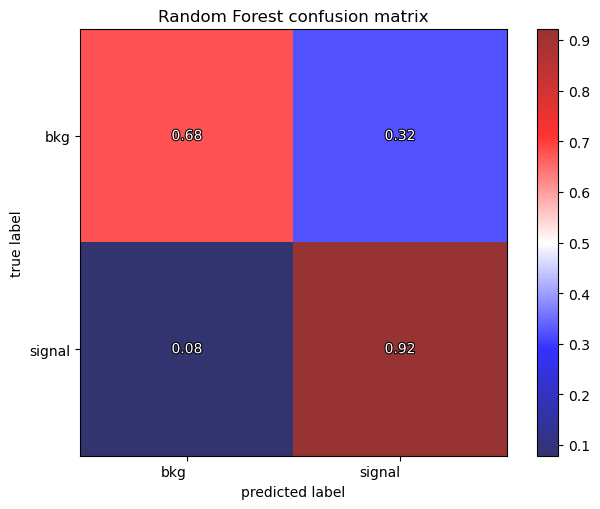

In [54]:
cm = confusion_matrix(Y_test,Y_pred)
RF_cm = normalize_cm(cm)

print('Confusion matrix:')
print(RF_cm)
plot_cm(RF_cm,method_name='Random Forest')


Finally we compute Q and plot the ROC curve

best random forest Q: 1.8145141679005308


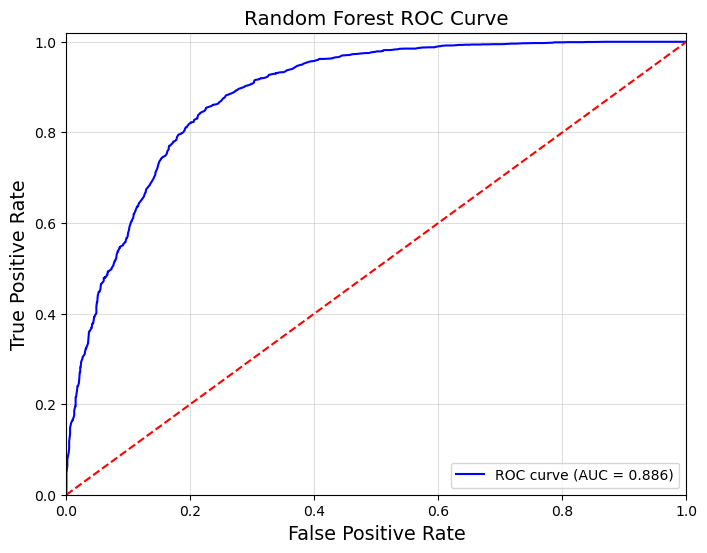

In [55]:
Q_rforest = get_best_Q(fpr,tpr)
fpr_rforest = fpr
tpr_rforest = tpr

print('best random forest Q:',Q_rforest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=1.5, label=f'ROC curve (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Random Forest ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

## Part 5.4: CNN
This part is about training a convolluted neural network to fit data. Different parameters are going to be trained in a manual grid search

In [56]:
# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)


In [63]:

# redefine NN cycle
hidden_layer_sizes = [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)]
learning_rate_init = [ 0.1 , 0.01 , 0.001 ]

start_time = time()

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 

parameters = []
fprs = []
tprs = []
aucs = []
partial_aucs = []
hls = []
lrs = []
models = []
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

for size in hidden_layer_sizes:
    for lr in learning_rate_init:
        print(f"Training MLP of size {size} and lr {lr}...")
        lrs.append(lr)
        hls.append(size)
        partial_auc = 0
        auc_value = 0

        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            print(f" Fold n. {i}")
            train_K=data_rescaled_and_indexed.iloc[train_idx]
            valid_K=data_rescaled_and_indexed.iloc[val_idx]
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            
            MLP = MLPClassifier(hidden_layer_sizes=size,
                                activation='relu', 
                                max_iter=600, 
                                alpha=1e-4, 
                                solver='sgd', 
                                tol=1e-4, 
                                learning_rate='adaptive',
                                learning_rate_init=lr,
                                verbose=0)
            
            MLP.fit(X_train_K,Y_train_K)
            parameters.append(MLP.coefs_)
            models.append(MLP)
            
            y_pred_proba = MLP.predict_proba(X_valid_K)[:, 1]  
    
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            print("AUC (Test set):", round(auc_value_k,3))
            
            # search for fpr less than 0.2 (if not able fpr is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc = 0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K                 
        partial_aucs.append(partial_auc)
        aucs.append(auc_value)
        
        elapsed_time = time() - start_time
        start_time = time()
        print('\n')
        print(f"Time needed for training: {elapsed_time:.2f} seconds")
        print("partial AUC:",round(partial_auc,3)," total AUC:",round(auc_value,3),'\n')


Training MLP of size (18,) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.878
 Fold n. 1
AUC (Test set): 0.878
 Fold n. 2
AUC (Test set): 0.878
 Fold n. 3
AUC (Test set): 0.882
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 31.16 seconds
partial AUC: 0.107  total AUC: 0.879 

Training MLP of size (18,) and lr 0.01...
 Fold n. 0
AUC (Test set): 0.873
 Fold n. 1
AUC (Test set): 0.873
 Fold n. 2
AUC (Test set): 0.869
 Fold n. 3
AUC (Test set): 0.876
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 46.02 seconds
partial AUC: 0.104  total AUC: 0.874 

Training MLP of size (18,) and lr 0.001...
 Fold n. 0
AUC (Test set): 0.86
 Fold n. 1
AUC (Test set): 0.86
 Fold n. 2
AUC (Test set): 0.864
 Fold n. 3
AUC (Test set): 0.863
 Fold n. 4
AUC (Test set): 0.865


Time needed for training: 79.39 seconds
partial AUC: 0.098  total AUC: 0.862 

Training MLP of size (36,) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.885
 Fold n. 1
AUC (Test set): 0.885
 Fold n. 2
AUC (Test set): 0.88

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.874
 Fold n. 1
AUC (Test set): 0.875
 Fold n. 2


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.876
 Fold n. 3


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.876
 Fold n. 4
AUC (Test set): 0.873


Time needed for training: 153.94 seconds
partial AUC: 0.105  total AUC: 0.875 

Training MLP of size (54, 18) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.882
 Fold n. 1
AUC (Test set): 0.873
 Fold n. 2
AUC (Test set): 0.886
 Fold n. 3
AUC (Test set): 0.878
 Fold n. 4
AUC (Test set): 0.885


Time needed for training: 123.96 seconds
partial AUC: 0.107  total AUC: 0.881 

Training MLP of size (54, 18) and lr 0.01...
 Fold n. 0
AUC (Test set): 0.88
 Fold n. 1
AUC (Test set): 0.881
 Fold n. 2
AUC (Test set): 0.884
 Fold n. 3
AUC (Test set): 0.878
 Fold n. 4
AUC (Test set): 0.882


Time needed for training: 134.93 seconds
partial AUC: 0.107  total AUC: 0.881 

Training MLP of size (54, 18) and lr 0.001...
 Fold n. 0


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.878
 Fold n. 1


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.879
 Fold n. 2


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.877
 Fold n. 3
AUC (Test set): 0.876
 Fold n. 4


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.879


Time needed for training: 222.06 seconds
partial AUC: 0.106  total AUC: 0.878 

Training MLP of size (54, 36) and lr 0.1...
 Fold n. 0
AUC (Test set): 0.871
 Fold n. 1
AUC (Test set): 0.862
 Fold n. 2
AUC (Test set): 0.871
 Fold n. 3
AUC (Test set): 0.861
 Fold n. 4
AUC (Test set): 0.87


Time needed for training: 244.69 seconds
partial AUC: 0.097  total AUC: 0.867 

Training MLP of size (54, 36) and lr 0.01...
 Fold n. 0
AUC (Test set): 0.883
 Fold n. 1
AUC (Test set): 0.887
 Fold n. 2
AUC (Test set): 0.882
 Fold n. 3
AUC (Test set): 0.886
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 195.04 seconds
partial AUC: 0.108  total AUC: 0.883 

Training MLP of size (54, 36) and lr 0.001...
 Fold n. 0


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.881
 Fold n. 1


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.876
 Fold n. 2


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.876
 Fold n. 3
AUC (Test set): 0.875
 Fold n. 4


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.878


Time needed for training: 300.88 seconds
partial AUC: 0.107  total AUC: 0.877 

Training MLP of size (54, 36, 18) and lr 0.1...
 Fold n. 0


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.842
 Fold n. 1
AUC (Test set): 0.848
 Fold n. 2
AUC (Test set): 0.849
 Fold n. 3
AUC (Test set): 0.857
 Fold n. 4
AUC (Test set): 0.854


Time needed for training: 356.08 seconds
partial AUC: 0.087  total AUC: 0.85 

Training MLP of size (54, 36, 18) and lr 0.01...
 Fold n. 0
AUC (Test set): 0.881
 Fold n. 1
AUC (Test set): 0.873
 Fold n. 2
AUC (Test set): 0.873
 Fold n. 3


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.865
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 314.40 seconds
partial AUC: 0.103  total AUC: 0.874 

Training MLP of size (54, 36, 18) and lr 0.001...
 Fold n. 0
AUC (Test set): 0.879
 Fold n. 1


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.88
 Fold n. 2


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.88
 Fold n. 3


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.881
 Fold n. 4
AUC (Test set): 0.878


Time needed for training: 422.59 seconds
partial AUC: 0.106  total AUC: 0.88 



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving the best model's performance and plotting it, as well as the confusion matrix

Confusion matrix:
[[0.634 0.366]
 [0.075 0.925]]


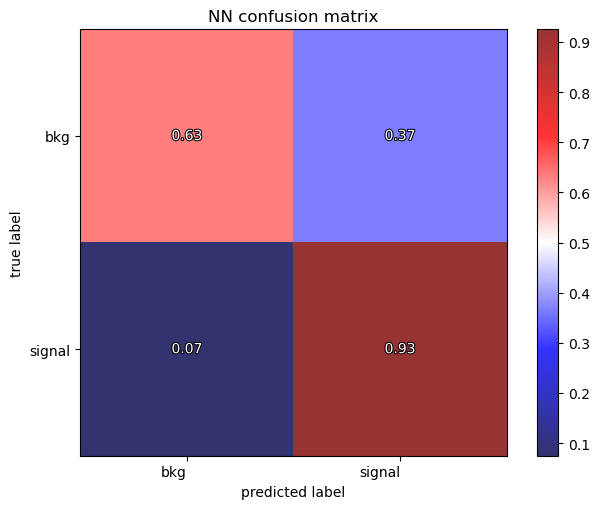

In [65]:
best_index_thresh = np.argmax(np.array(partial_aucs))
best_auc_thresh = aucs[best_index_thresh]
best_fpr_thresh = fprs[best_index_thresh]
best_tpr_thresh = tprs[best_index_thresh]
best_model_NN = models[best_index_thresh]

#print(best_model)
Y_pred = best_model_NN.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
NN_cm = normalize_cm(cm)

print('Confusion matrix:')
print(NN_cm)
plot_cm(NN_cm,method_name='NN')


best NN Q value: 1.699
best NN ROC area: 0.873


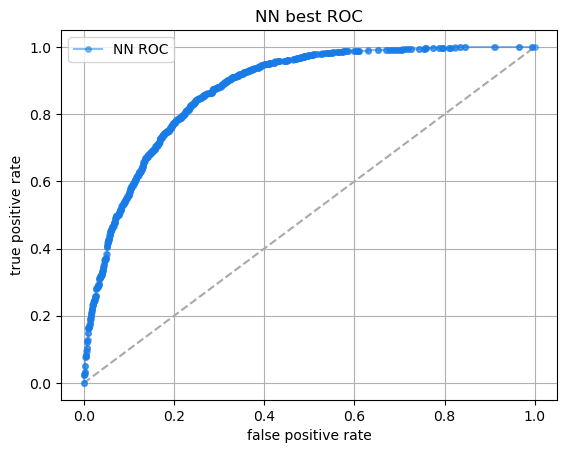

In [66]:
fpr_NN = best_fpr_thresh
tpr_NN = best_tpr_thresh
Q_NN = get_best_Q(fpr_NN,tpr_NN)
auc_value = auc(fpr_NN, tpr_NN)

print('best NN Q value:',round(Q_NN,3))
print('best NN ROC area:',round(auc_value,3))

plt.grid()
plt.title('NN best ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='darkgrey')
plt.plot(best_fpr_thresh,best_tpr_thresh,marker='o',label='NN ROC',ms=4,alpha=0.5,c='#197ce6')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()


Now we plot them all

best NN Q value: 1.699
best perceptron Q value: 1.065
best SVM Q value: 1.683
best random forest Q value: 1.815


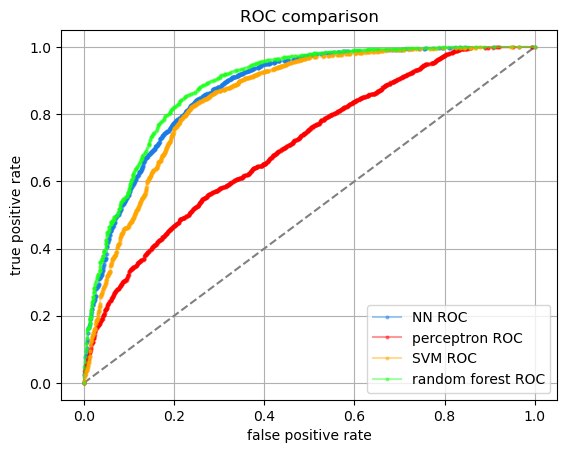

In [67]:
print('best NN Q value:',Q_NN.round(3))
print('best perceptron Q value:',Q_perceptron.round(3))
print('best SVM Q value:',Q_SVM.round(3))
print('best random forest Q value:',Q_rforest.round(3))

plt.grid()
plt.title('ROC comparison')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr_NN,tpr_NN,marker='o',label='NN ROC',ms=2,alpha=0.4,c='#197ce6')
plt.plot(fpr_perceptron,tpr_perceptron,marker='o',label='perceptron ROC',ms=2,alpha=0.4,c='red')
plt.plot(fpr_SVM,tpr_SVM,marker='o',label='SVM ROC',ms=2,alpha=0.4,c='orange')
plt.plot(fpr_rforest,tpr_rforest,marker='o',label='random forest ROC',ms=2,alpha=0.4,c='#1aff1a')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

## Part 5.5: Logistic Regression (version 3)

Logistic regression allows to pose a classification problem as a regression problem, where the predicted label is the probability for a sample to belong to a certain class. Thus, in our case the output of the algorithm is the *gammaness*. We can then choose a threshold for the *gammaness* to assign gamma (+1) as the predicted label. The learning problem is to find the sigmoid function
$\sigma_{\mathbf{w}}(\mathbf{x}) =\frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x})}}$
that minimizes the loss:

$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) + \lambda||\mathbf{w}||^2
$$
where: 
$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) = -\sum_{i=1}^{n} \left[ y_i \log(\sigma_{\mathbf{w}}(\mathbf{x}_i)) + (1 - y_i) \log(1 - \sigma_{\mathbf{w}}(\mathbf{x}_i)) \right]$$
and we use the Tikhonov regularization technique to prevent overfitting.

To find the best hyper-parameter $C=\frac{1}{\lambda}$ for model we choose the usual 0.5 threshold for the *gammaness* and perform a K-fold cross validation, where again we keep as best model the one that maximizes the partial AUC. 

In [68]:
from sklearn.linear_model import LogisticRegression
from time import time
auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict') 

# hyper-parameters 
param_grid = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]} # we use Tikhonov regularization: in the loss we add a term proportional to the norm squared of w (C=1/lambda)

# grid search with K-fold validation
K=5

fprs = []
tprs = []
aucs = []
partial_aucs = []
C = []
for c in param_grid['C']:
        auc_value=0
        partial_auc=0
        print(f"Training model with regularization constant c = {c}")
        C.append(c)
        for i in range(K):
            train_K, valid_K = split_train_test_set(train_set,K)
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            model= LogisticRegression(penalty='l2',C=c,solver='lbfgs',max_iter=300) # 'lbfgs' approximates up to the the second derivative of the loss function to optimize the coefficients, best for large datasets 
            model.fit(X_train_K,Y_train_K)
                    
            y_pred_proba = model.predict_proba(X_valid_K)[:, 1]  
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            # keep fpr less than 0.2 (if not able to find it, partial auc is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc=0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K
        print('Partial AUC:', partial_auc)
        partial_aucs.append(partial_auc)
        print('AUC:', auc_value,'\n')
        aucs.append(auc_value)                

Training model with regularization constant c = 0.001
Partial AUC: 0.04388686478242459
AUC: 0.7056025447324716 

Training model with regularization constant c = 0.005
Partial AUC: 0.04192018610634245
AUC: 0.7050984631362749 

Training model with regularization constant c = 0.01
Partial AUC: 0.042617004004416564
AUC: 0.7119437514995918 

Training model with regularization constant c = 0.05
Partial AUC: 0.04417303512236097
AUC: 0.7178662520394348 

Training model with regularization constant c = 0.1
Partial AUC: 0.04259323759292742
AUC: 0.715945772551954 

Training model with regularization constant c = 0.5
Partial AUC: 0.045584583289772426
AUC: 0.715865536895904 

Training model with regularization constant c = 1
Partial AUC: 0.0430879835702905
AUC: 0.7123712332112437 

Training model with regularization constant c = 5
Partial AUC: 0.046438002827990744
AUC: 0.7248481958816158 

Training model with regularization constant c = 10
Partial AUC: 0.04100856247352648
AUC: 0.7062522469416461 



In [69]:
best_partial_auc = np.max(np.array(partial_aucs))
best_auc= np.max(np.array(aucs))
best_index = np.where(partial_aucs==best_partial_auc)[0]
print('Best model with regularization constant c=',C[best_index[0]])
print('Best partial AUC (validation set):', best_partial_auc)
print('AUC of best model (validation set):', best_auc,'\n')

best_model = LogisticRegression(penalty='l2', C= C[best_index[0]],solver='lbfgs',max_iter=300)
best_model.fit(X_train,Y_train) # retrain the best
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  
fpr_test, tpr_test, _ = roc_curve(Y_test, y_pred_proba_test)
auc_test= auc(fpr_test,tpr_test)

partial_fpr_test = fpr_test[fpr_test <= 0.2]
if (len(partial_fpr_test)<2):
    partial_auc_test=0
else:
    partial_tpr_test = tpr_test[:len(partial_fpr_test)]
    partial_auc_test = auc(partial_fpr_test, partial_tpr_test)
print('Best partial AUC (test set):', partial_auc_test)
print('AUC of best model (test set):', auc_test)
Q_log = get_best_Q(fpr_test,tpr_test)
print('Q value of best model:',Q_log)

Best model with regularization constant c= 5
Best partial AUC (validation set): 0.046438002827990744
AUC of best model (validation set): 0.7248481958816158 

Best partial AUC (test set): 0.04484106218674475
AUC of best model (test set): 0.7187709656050647
Q value of best model: 1.1540908745078695


We get the confusion matrix:

Confusion matrix:
[[0.345 0.655]
 [0.052 0.948]]


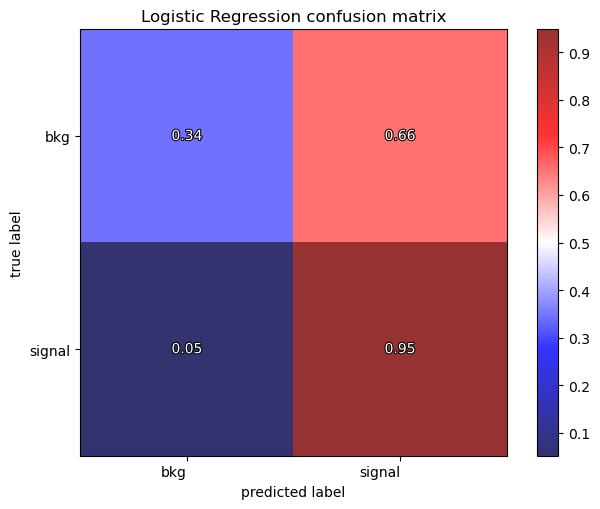

In [70]:
Y_pred = best_model.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
log_cm = normalize_cm(cm)

print('Confusion matrix:')
print(log_cm)
plot_cm(log_cm,method_name='Logistic Regression')


Here we plot the best model ROC curve

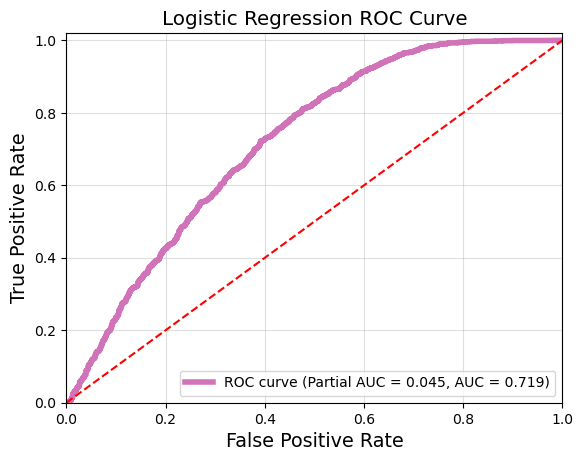

In [71]:
fpr_log = fpr_test
tpr_log = tpr_test

plt.figure()
plt.plot(fpr_test, tpr_test, color='#d173b8', lw=4, label=f'ROC curve (Partial AUC = {partial_auc_test:.3f}, AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Logistic Regression ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

And here we plot all ROCs

best log_reg Q value: 1.154
best NN Q value: 1.699
best perceptron Q value: 1.065
best SVM Q value: 1.683
best random forest Q value: 1.815


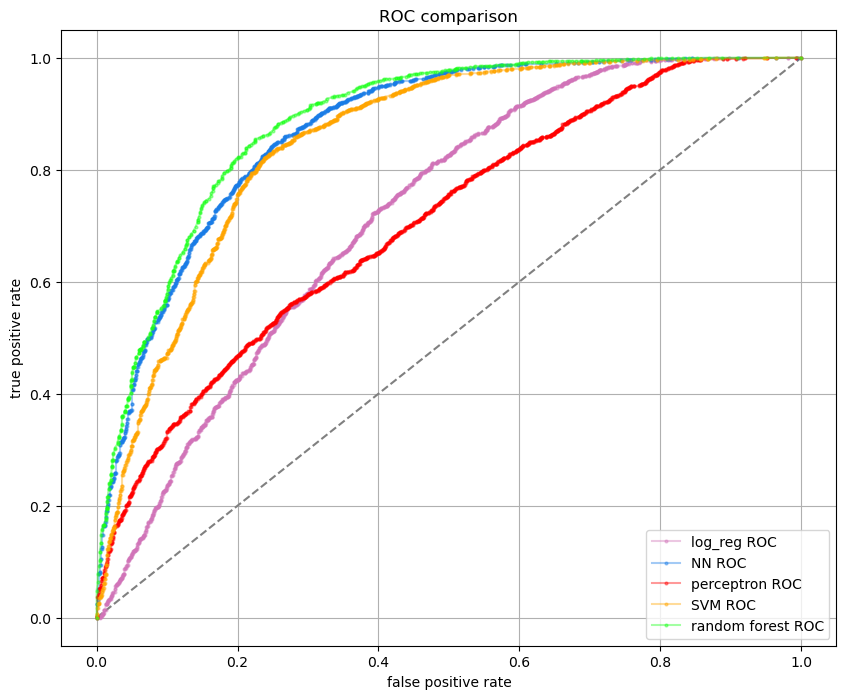

In [72]:
print('best log_reg Q value:',Q_log.round(3))
print('best NN Q value:',Q_NN.round(3))
print('best perceptron Q value:',Q_perceptron.round(3))
print('best SVM Q value:',Q_SVM.round(3))
print('best random forest Q value:',Q_rforest.round(3))


plt.figure(figsize=(10,8))
plt.grid()
plt.title('ROC comparison')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr_log,tpr_log,marker='o',label='log_reg ROC',ms=2,alpha=0.4,c='#d173b8')
plt.plot(fpr_NN,tpr_NN,marker='o',label='NN ROC',ms=2,alpha=0.4,c='#197ce6')
plt.plot(fpr_perceptron,tpr_perceptron,marker='o',label='perceptron ROC',ms=2,alpha=0.4,c='red')
plt.plot(fpr_SVM,tpr_SVM,marker='o',label='SVM ROC',ms=2,alpha=0.4,c='orange')
plt.plot(fpr_rforest,tpr_rforest,marker='o',label='random forest ROC',ms=2,alpha=0.4,c='#1aff1a')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

# Part 6: cutting on alpha parameter
In this section a cut on alpha parameter is going to be performed. The best value for alpha is going to be determined, as well as the value that lets only 10% of hadron to be accepted as fp
## NOTE: Alpha param is not rescaled!

In [73]:
X_train['fAlpha'] = train_alpha
X_test['fAlpha'] = test_alpha
print(X_train.columns[:])
print(X_train.shape[:])

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fDist', 'fAlpha'],
      dtype='object')
(15216, 10)


total gammas: 2458 tot hadrons: 1345 tot test points: 3803
best cut value is Alpha = 1.618 with rate: 0.9505
#tp: 307   #fp: 16
rate of saved gammas: 0.1249
 
given threshold rate = 0.9, best cut is: 7.383 with rate 0.9003
#tp: 1066 #fp: 118 rate of saved gammas: 0.4337


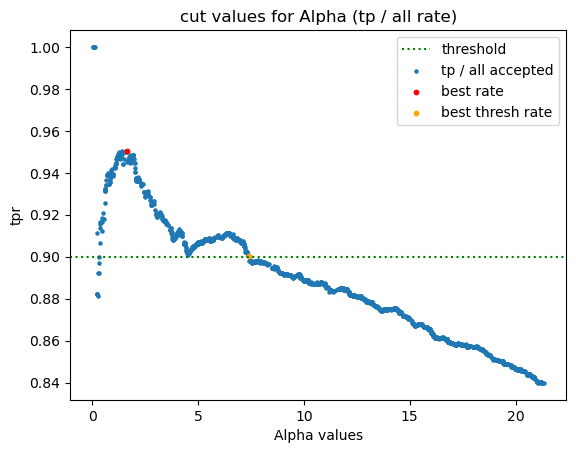

In [85]:
tot_hadrons = len(Y_test[Y_test == -1])
tot_gammas = len(Y_test[Y_test == 1])
tot_hadrons_train = len(Y_train[Y_train == -1])
sel_label = 9
# sel label = Alpha == 9

cut_values = []
rates = []
absolute_tp = []
absolute_fp = []

# setting minimum threshold as 0.90 (editable)
thresh = 0.90

#print('cut value    tp    fp     tp / all')
for i in range(1,tot_hadrons):
    cut_value = find_max_cut_value(X_train,Y_train,sel_label,i)
    
    # to check how the cut value behaves we get the results on test set
    tp, fp = find_tp_fp(X_test,Y_test,sel_label,cut_value)
    if (tp+fp == 0):
        tp = 1
    #print(cut_value,'  ',tp,'  ',fp,'  ',tp/(tp+fp))
    cut_values.append(cut_value)
    rates.append(tp/(tp+fp))
    absolute_tp.append(tp)
    absolute_fp.append(fp)
    
    if (tp/(tp+fp) > thresh):
        best_cut_thresh = cut_value
        rate_thresh = tp/(tp+fp)
        tp_thresh = tp
        fp_thresh = fp

rates = np.array(rates)
mask = np.where(rates < 1,rates,0)
index = np.argmax(mask)
best_rate = rates[index]
best_cut = cut_values[index]
best_tp = absolute_tp[index]
best_fp = absolute_fp[index]

print('total gammas:',tot_gammas,'tot hadrons:',tot_hadrons,'tot test points:',tot_gammas+tot_hadrons)
print('best cut value is Alpha =',round(best_cut,4),'with rate:',round(best_rate,4))
print('#tp:',best_tp,'  #fp:',best_fp)
print('rate of saved gammas:',round(best_tp / tot_gammas,4))
print(' ')
print('given threshold rate = 0.9, best cut is:',round(best_cut_thresh,4),'with rate',round(rate_thresh,4))
print('#tp:',tp_thresh,'#fp:',fp_thresh,'rate of saved gammas:',round(tp_thresh / tot_gammas,4))

plt.axhline(y=0.9, color='g', linestyle=':',label='threshold')  # Dotted green line
plt.scatter(cut_values,rates, s= 5,label='tp / all accepted')
plt.scatter(best_cut,best_rate,c='red',s=10,label='best rate')
plt.scatter(best_cut_thresh,rate_thresh,c='orange',s=10,label='best thresh rate')
plt.legend()
plt.title('cut values for Alpha (tp / all rate)')
plt.xlabel('Alpha values')
plt.ylabel('tpr')
plt.show();



# Part 7: grid search in alpha cut

In [86]:
print(best_forest)

RandomForestClassifier(max_depth=38, max_features=9, max_samples=1.0,
                       n_estimators=290, n_jobs=-1, random_state=10)


We now apply the best model found in the previous part, i.e: the Random Forest, to look for the combination of parameters *gammaness* and *alpha_cut* that maximizes the quality factor *Q*. What we do is label as background (hadrons) all samples with fAlpha greater than the *alpha_cut* value considered; then we apply the best Random Forest classification to the remaining samples, labelling as gammas only the samples with a predicted probability of belonging to class +1 greater than *gammaness*. Then we determine the TPR and FPR to calculate the correspondent Q value.    
To avoid choosing the best combination of *alpha cut* and *gammaness* solely on the performance on a specific test set, we run the same algorithm on different test sets and choose as best case the one that returns the highest average Q value over the iterations.

In [87]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

file_name="magic04.data.7"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']


In [88]:
data_rescaled = data
original_alpha = data['fAlpha'].copy()

for i in data.drop(columns=['category']).columns:
    h = data[i]
    avg = np.mean(h.astype(float))
    std = np.std(h)
    h = h - avg
    h = h / std
    data_rescaled[i]= h
    
print('avg length:',np.average(data_rescaled['fLength']))
print('dev_std length:',np.std(data_rescaled['fLength']))
data_rescaled['fAlpha'] = original_alpha
data_rescaled['category'] = data['category']
data_rescaled['category'] = data_rescaled['category'].replace({'g':1,'h':-1})


avg length: 3.5865241407523854e-17
dev_std length: 0.9999999999999971


In [91]:
N=10
test_predictions=[]
gammaness= np.arange(0.8,0.96,0.01)
alpha_cut= np.arange(2,15,1)

# getting best forest params (for some reason those are in a dict inside a dict)
params = best_forest.get_params()

for i in range(1,N+1):
    print('Iteration:',i,'\n')
    
    train_set, test_set = split_train_test_set( data_rescaled, 5)
    X_train, Y_train = split_X_Y(train_set)
    X_test, Y_test = split_X_Y(test_set)
    
    best_forest = RandomForestClassifier(
        n_estimators = params['n_estimators'], 
        max_depth = params['max_depth'], 
        max_features = X_train.shape[1],
        bootstrap = params['bootstrap'],
        max_samples = params['max_samples'],
        random_state = params['random_state'],
        n_jobs=-1)
    
    best_forest.fit(X_train,Y_train) 

    for alpha in alpha_cut:
        print('\n')
        for g in gammaness:

            test_data = [ X_test[ X_test['fAlpha']<alpha], Y_test[X_test['fAlpha']<alpha] ] 
            
            discarded_data = X_test[X_test['fAlpha'] >= alpha]
            discarded_labels = Y_test[X_test['fAlpha'] >= alpha] # we directly classify these points as hadrons 
            
            y_pred_prob = best_forest.predict_proba(test_data[0])[:, 1]
            y_pred_label = np.where(y_pred_prob > g, 1, -1)
        
            selected_gammas= np.sum(y_pred_label==1)
            selected_hadrons= np.sum(y_pred_label==-1) + ( X_test.shape[0]-len(test_data[0])) # samples in alpha cut classified as hadron by the model + all samples previously discarded
    
            total_gammas = np.sum(Y_test==1) # over all the test set (before alpha cut)
            total_hadrons = np.sum(Y_test==-1)
            
            true_positives = np.sum( (y_pred_label==1) & (test_data[1]==1) )
            false_positives = np.sum( (y_pred_label==1) & (test_data[1]==-1) )
            true_negatives= np.sum((y_pred_label == -1) & (test_data[1] == -1)) + np.sum((discarded_labels == -1))
            false_negatives= np.sum((y_pred_label == -1) & (test_data[1] == 1)) + np.sum((discarded_labels == 1))
            
            if false_positives != 0:
                epsilon_gamma = true_positives / total_gammas # TPR
                epsilon_hadron = false_positives / total_hadrons # FPR
                Q = epsilon_gamma/np.sqrt(epsilon_hadron)
            else:
                epsilon_hadron= 0
                epsilon_gamma = true_positives / total_gammas
                Q = 'inf'
                
            test_predictions.append({
            'iteration': i,   
            'alpha_cut': alpha,
            'gamma': g,
            'test_data': test_data, 
            'pred_probs': y_pred_prob,
            'pred label': y_pred_label,
            'selected gammas': selected_gammas,
            'selected hadrons': selected_hadrons,
            'total gammas': total_gammas,
            'total hadrons': total_hadrons,
            'true positives': true_positives,
            'false positives': false_positives,
            'true negatives': true_negatives,
            'false negatives': false_negatives,
            'Q': Q })

            if Q != 'inf':
                print(f"With alpha cut {alpha} and gammaness {g:.2f}, Q = {Q:.4f}")
            else:
                print(f"With alpha cut {alpha} and gammanesss {g:.2f}, Q = {Q}")
            print(f"True positives {true_positives}; False positives {false_positives}")
    

Iteration: 1 



With alpha cut 2 and gammaness 0.80, Q = 1.2867
True positives 328; False positives 16
With alpha cut 2 and gammaness 0.81, Q = 1.3249
True positives 327; False positives 15
With alpha cut 2 and gammaness 0.82, Q = 1.3588
True positives 324; False positives 14
With alpha cut 2 and gammaness 0.83, Q = 1.5234
True positives 322; False positives 11
With alpha cut 2 and gammaness 0.84, Q = 1.5140
True positives 320; False positives 11
With alpha cut 2 and gammaness 0.85, Q = 1.4856
True positives 314; False positives 11
With alpha cut 2 and gammaness 0.86, Q = 1.4714
True positives 311; False positives 11
With alpha cut 2 and gammaness 0.87, Q = 1.4714
True positives 311; False positives 11
With alpha cut 2 and gammaness 0.88, Q = 1.5283
True positives 308; False positives 10
With alpha cut 2 and gammaness 0.89, Q = 1.5849
True positives 303; False positives 9
With alpha cut 2 and gammaness 0.90, Q = 1.5378
True positives 294; False positives 9
With alpha cut 2 and gammane

With alpha cut 7 and gammaness 0.95, Q = 2.9776
True positives 710; False positives 14


With alpha cut 8 and gammaness 0.80, Q = 2.4479
True positives 1011; False positives 42
With alpha cut 8 and gammaness 0.81, Q = 2.4702
True positives 1008; False positives 41
With alpha cut 8 and gammaness 0.82, Q = 2.5102
True positives 999; False positives 39
With alpha cut 8 and gammaness 0.83, Q = 2.5970
True positives 993; False positives 36
With alpha cut 8 and gammaness 0.84, Q = 2.5865
True positives 989; False positives 36
With alpha cut 8 and gammaness 0.85, Q = 2.6660
True positives 976; False positives 33
With alpha cut 8 and gammaness 0.86, Q = 2.6630
True positives 960; False positives 32
With alpha cut 8 and gammaness 0.87, Q = 2.6802
True positives 951; False positives 31
With alpha cut 8 and gammaness 0.88, Q = 2.7934
True positives 942; False positives 28
With alpha cut 8 and gammaness 0.89, Q = 2.8496
True positives 926; False positives 26
With alpha cut 8 and gammaness 0.90, Q 

With alpha cut 13 and gammaness 0.92, Q = 2.9867
True positives 1025; False positives 29
With alpha cut 13 and gammaness 0.93, Q = 2.9474
True positives 976; False positives 27
With alpha cut 13 and gammaness 0.94, Q = 2.9500
True positives 921; False positives 24
With alpha cut 13 and gammaness 0.95, Q = 3.0596
True positives 872; False positives 20


With alpha cut 14 and gammaness 0.80, Q = 2.6311
True positives 1277; False positives 58
With alpha cut 14 and gammaness 0.81, Q = 2.6396
True positives 1270; False positives 57
With alpha cut 14 and gammaness 0.82, Q = 2.6799
True positives 1255; False positives 54
With alpha cut 14 and gammaness 0.83, Q = 2.7841
True positives 1242; False positives 49
With alpha cut 14 and gammaness 0.84, Q = 2.8244
True positives 1234; False positives 47
With alpha cut 14 and gammaness 0.85, Q = 2.8695
True positives 1213; False positives 44
With alpha cut 14 and gammaness 0.86, Q = 2.8500
True positives 1191; False positives 43
With alpha cut 14 and 

With alpha cut 6 and gammaness 0.90, Q = 2.6813
True positives 769; False positives 18
With alpha cut 6 and gammaness 0.91, Q = 2.7232
True positives 759; False positives 17
With alpha cut 6 and gammaness 0.92, Q = 2.7108
True positives 733; False positives 16
With alpha cut 6 and gammaness 0.93, Q = 3.1088
True positives 697; False positives 11
With alpha cut 6 and gammaness 0.94, Q = 3.2643
True positives 662; False positives 9
With alpha cut 6 and gammaness 0.95, Q = 3.2008
True positives 612; False positives 8


With alpha cut 7 and gammaness 0.80, Q = 2.3229
True positives 929; False positives 35
With alpha cut 7 and gammaness 0.81, Q = 2.3846
True positives 926; False positives 33
With alpha cut 7 and gammaness 0.82, Q = 2.5190
True positives 917; False positives 29
With alpha cut 7 and gammaness 0.83, Q = 2.5496
True positives 912; False positives 28
With alpha cut 7 and gammaness 0.84, Q = 2.5049
True positives 896; False positives 28
With alpha cut 7 and gammaness 0.85, Q = 2.

With alpha cut 12 and gammaness 0.89, Q = 2.8321
True positives 1083; False positives 32
With alpha cut 12 and gammaness 0.90, Q = 3.0149
True positives 1059; False positives 27
With alpha cut 12 and gammaness 0.91, Q = 3.0651
True positives 1036; False positives 25
With alpha cut 12 and gammaness 0.92, Q = 3.0661
True positives 994; False positives 23
With alpha cut 12 and gammaness 0.93, Q = 3.3546
True positives 935; False positives 17
With alpha cut 12 and gammaness 0.94, Q = 3.3612
True positives 880; False positives 15
With alpha cut 12 and gammaness 0.95, Q = 3.4590
True positives 810; False positives 12


With alpha cut 13 and gammaness 0.80, Q = 2.5233
True positives 1265; False positives 55
With alpha cut 13 and gammaness 0.81, Q = 2.6276
True positives 1256; False positives 50
With alpha cut 13 and gammaness 0.82, Q = 2.7323
True positives 1239; False positives 45
With alpha cut 13 and gammaness 0.83, Q = 2.7408
True positives 1229; False positives 44
With alpha cut 13 and g

With alpha cut 5 and gammaness 0.88, Q = 2.4507
True positives 712; False positives 17
With alpha cut 5 and gammaness 0.89, Q = 2.5048
True positives 706; False positives 16
With alpha cut 5 and gammaness 0.90, Q = 2.6512
True positives 699; False positives 14
With alpha cut 5 and gammaness 0.91, Q = 2.6247
True positives 692; False positives 14
With alpha cut 5 and gammaness 0.92, Q = 2.5526
True positives 673; False positives 14
With alpha cut 5 and gammaness 0.93, Q = 2.5348
True positives 644; False positives 13
With alpha cut 5 and gammaness 0.94, Q = 2.5236
True positives 616; False positives 12
With alpha cut 5 and gammaness 0.95, Q = 2.5160
True positives 588; False positives 11


With alpha cut 6 and gammaness 0.80, Q = 2.3628
True positives 881; False positives 28
With alpha cut 6 and gammaness 0.81, Q = 2.3925
True positives 876; False positives 27
With alpha cut 6 and gammaness 0.82, Q = 2.3761
True positives 870; False positives 27
With alpha cut 6 and gammaness 0.83, Q = 

With alpha cut 11 and gammaness 0.88, Q = 2.7064
True positives 1112; False positives 34
With alpha cut 11 and gammaness 0.89, Q = 2.7496
True positives 1096; False positives 32
With alpha cut 11 and gammaness 0.90, Q = 2.7776
True positives 1072; False positives 30
With alpha cut 11 and gammaness 0.91, Q = 2.7232
True positives 1051; False positives 30
With alpha cut 11 and gammaness 0.92, Q = 2.7776
True positives 1017; False positives 27
With alpha cut 11 and gammaness 0.93, Q = 2.7983
True positives 966; False positives 24
With alpha cut 11 and gammaness 0.94, Q = 2.9163
True positives 919; False positives 20
With alpha cut 11 and gammaness 0.95, Q = 3.0618
True positives 863; False positives 16


With alpha cut 12 and gammaness 0.80, Q = 2.5132
True positives 1277; False positives 52
With alpha cut 12 and gammaness 0.81, Q = 2.5158
True positives 1266; False positives 51
With alpha cut 12 and gammaness 0.82, Q = 2.5543
True positives 1247; False positives 48
With alpha cut 12 and 

With alpha cut 4 and gammaness 0.87, Q = 1.9339
True positives 607; False positives 22
With alpha cut 4 and gammaness 0.88, Q = 1.9533
True positives 599; False positives 21
With alpha cut 4 and gammaness 0.89, Q = 2.0676
True positives 587; False positives 18
With alpha cut 4 and gammaness 0.90, Q = 2.0695
True positives 571; False positives 17
With alpha cut 4 and gammaness 0.91, Q = 2.2405
True positives 561; False positives 14
With alpha cut 4 and gammaness 0.92, Q = 2.2547
True positives 544; False positives 13
With alpha cut 4 and gammaness 0.93, Q = 2.2950
True positives 532; False positives 12
With alpha cut 4 and gammaness 0.94, Q = 2.3959
True positives 507; False positives 10
With alpha cut 4 and gammaness 0.95, Q = 2.5043
True positives 474; False positives 8


With alpha cut 5 and gammaness 0.80, Q = 2.0237
True positives 754; False positives 31
With alpha cut 5 and gammaness 0.81, Q = 2.0544
True positives 753; False positives 30
With alpha cut 5 and gammaness 0.82, Q = 2

With alpha cut 10 and gammaness 0.87, Q = 2.6699
True positives 1072; False positives 36
With alpha cut 10 and gammaness 0.88, Q = 2.7012
True positives 1054; False positives 34
With alpha cut 10 and gammaness 0.89, Q = 2.7618
True positives 1029; False positives 31
With alpha cut 10 and gammaness 0.90, Q = 2.7694
True positives 998; False positives 29
With alpha cut 10 and gammaness 0.91, Q = 2.9140
True positives 975; False positives 25
With alpha cut 10 and gammaness 0.92, Q = 2.9948
True positives 940; False positives 22
With alpha cut 10 and gammaness 0.93, Q = 2.9446
True positives 903; False positives 21
With alpha cut 10 and gammaness 0.94, Q = 2.9175
True positives 851; False positives 19
With alpha cut 10 and gammaness 0.95, Q = 2.9327
True positives 785; False positives 16


With alpha cut 11 and gammaness 0.80, Q = 2.4652
True positives 1201; False positives 53
With alpha cut 11 and gammaness 0.81, Q = 2.5027
True positives 1196; False positives 51
With alpha cut 11 and gam

With alpha cut 3 and gammaness 0.84, Q = 1.9163
True positives 470; False positives 13
With alpha cut 3 and gammaness 0.85, Q = 1.9000
True positives 466; False positives 13
With alpha cut 3 and gammaness 0.86, Q = 1.8837
True positives 462; False positives 13
With alpha cut 3 and gammaness 0.87, Q = 1.9394
True positives 457; False positives 12
With alpha cut 3 and gammaness 0.88, Q = 1.9097
True positives 450; False positives 12
With alpha cut 3 and gammaness 0.89, Q = 1.9414
True positives 438; False positives 11
With alpha cut 3 and gammaness 0.90, Q = 1.9060
True positives 430; False positives 11
With alpha cut 3 and gammaness 0.91, Q = 1.8838
True positives 425; False positives 11
With alpha cut 3 and gammaness 0.92, Q = 1.9060
True positives 410; False positives 10
With alpha cut 3 and gammaness 0.93, Q = 2.0738
True positives 399; False positives 8
With alpha cut 3 and gammaness 0.94, Q = 2.0948
True positives 377; False positives 7
With alpha cut 3 and gammaness 0.95, Q = 2.12

With alpha cut 9 and gammaness 0.84, Q = 2.2576
True positives 1007; False positives 43
With alpha cut 9 and gammaness 0.85, Q = 2.2867
True positives 996; False positives 41
With alpha cut 9 and gammaness 0.86, Q = 2.3164
True positives 984; False positives 39
With alpha cut 9 and gammaness 0.87, Q = 2.3419
True positives 969; False positives 37
With alpha cut 9 and gammaness 0.88, Q = 2.4052
True positives 954; False positives 34
With alpha cut 9 and gammaness 0.89, Q = 2.3953
True positives 936; False positives 33
With alpha cut 9 and gammaness 0.90, Q = 2.3922
True positives 906; False positives 31
With alpha cut 9 and gammaness 0.91, Q = 2.3473
True positives 889; False positives 31
With alpha cut 9 and gammaness 0.92, Q = 2.4473
True positives 865; False positives 27
With alpha cut 9 and gammaness 0.93, Q = 2.4877
True positives 829; False positives 24
With alpha cut 9 and gammaness 0.94, Q = 2.5575
True positives 778; False positives 20
With alpha cut 9 and gammaness 0.95, Q = 2

With alpha cut 2 and gammaness 0.82, Q = 1.9320
True positives 345; False positives 7
With alpha cut 2 and gammaness 0.83, Q = 1.8984
True positives 339; False positives 7
With alpha cut 2 and gammaness 0.84, Q = 2.0323
True positives 336; False positives 6
With alpha cut 2 and gammaness 0.85, Q = 2.0142
True positives 333; False positives 6
With alpha cut 2 and gammaness 0.86, Q = 1.9961
True positives 330; False positives 6
With alpha cut 2 and gammaness 0.87, Q = 1.9719
True positives 326; False positives 6
With alpha cut 2 and gammaness 0.88, Q = 2.1071
True positives 318; False positives 5
With alpha cut 2 and gammaness 0.89, Q = 2.0739
True positives 313; False positives 5
With alpha cut 2 and gammaness 0.90, Q = 2.0143
True positives 304; False positives 5
With alpha cut 2 and gammaness 0.91, Q = 2.1854
True positives 295; False positives 4
With alpha cut 2 and gammaness 0.92, Q = 2.0891
True positives 282; False positives 4
With alpha cut 2 and gammaness 0.93, Q = 2.0372
True p

With alpha cut 8 and gammaness 0.82, Q = 2.5015
True positives 1013; False positives 36
With alpha cut 8 and gammaness 0.83, Q = 2.4694
True positives 1000; False positives 36
With alpha cut 8 and gammaness 0.84, Q = 2.5508
True positives 989; False positives 33
With alpha cut 8 and gammaness 0.85, Q = 2.5301
True positives 981; False positives 33
With alpha cut 8 and gammaness 0.86, Q = 2.4992
True positives 969; False positives 33
With alpha cut 8 and gammaness 0.87, Q = 2.5065
True positives 957; False positives 32
With alpha cut 8 and gammaness 0.88, Q = 2.6292
True positives 939; False positives 28
With alpha cut 8 and gammaness 0.89, Q = 2.7232
True positives 919; False positives 25
With alpha cut 8 and gammaness 0.90, Q = 2.6977
True positives 892; False positives 24
With alpha cut 8 and gammaness 0.91, Q = 2.7576
True positives 873; False positives 22
With alpha cut 8 and gammaness 0.92, Q = 2.7895
True positives 842; False positives 20
With alpha cut 8 and gammaness 0.93, Q = 

With alpha cut 13 and gammaness 0.95, Q = 3.2985
True positives 833; False positives 14


With alpha cut 14 and gammaness 0.80, Q = 2.6095
True positives 1318; False positives 56
With alpha cut 14 and gammaness 0.81, Q = 2.6071
True positives 1305; False positives 55
With alpha cut 14 and gammaness 0.82, Q = 2.6150
True positives 1297; False positives 54
With alpha cut 14 and gammaness 0.83, Q = 2.5948
True positives 1275; False positives 53
With alpha cut 14 and gammaness 0.84, Q = 2.6903
True positives 1258; False positives 48
With alpha cut 14 and gammaness 0.85, Q = 2.6841
True positives 1242; False positives 47
With alpha cut 14 and gammaness 0.86, Q = 2.6717
True positives 1223; False positives 46
With alpha cut 14 and gammaness 0.87, Q = 2.6937
True positives 1206; False positives 44
With alpha cut 14 and gammaness 0.88, Q = 2.7782
True positives 1171; False positives 39
With alpha cut 14 and gammaness 0.89, Q = 2.8200
True positives 1142; False positives 36
With alpha cut 14 an

With alpha cut 6 and gammaness 0.93, Q = 2.1511
True positives 687; False positives 21
With alpha cut 6 and gammaness 0.94, Q = 2.1693
True positives 659; False positives 19
With alpha cut 6 and gammaness 0.95, Q = 2.1576
True positives 620; False positives 17


With alpha cut 7 and gammaness 0.80, Q = 2.0333
True positives 940; False positives 44
With alpha cut 7 and gammaness 0.81, Q = 2.0160
True positives 932; False positives 44
With alpha cut 7 and gammaness 0.82, Q = 2.0706
True positives 924; False positives 41
With alpha cut 7 and gammaness 0.83, Q = 2.1115
True positives 919; False positives 39
With alpha cut 7 and gammaness 0.84, Q = 2.1228
True positives 912; False positives 38
With alpha cut 7 and gammaness 0.85, Q = 2.0902
True positives 898; False positives 38
With alpha cut 7 and gammaness 0.86, Q = 2.0782
True positives 881; False positives 37
With alpha cut 7 and gammaness 0.87, Q = 2.1458
True positives 872; False positives 34
With alpha cut 7 and gammaness 0.88, Q = 

With alpha cut 12 and gammaness 0.92, Q = 2.4423
True positives 1007; False positives 35
With alpha cut 12 and gammaness 0.93, Q = 2.3779
True positives 952; False positives 33
With alpha cut 12 and gammaness 0.94, Q = 2.3682
True positives 904; False positives 30
With alpha cut 12 and gammaness 0.95, Q = 2.3085
True positives 836; False positives 27


With alpha cut 13 and gammaness 0.80, Q = 2.2231
True positives 1287; False positives 69
With alpha cut 13 and gammaness 0.81, Q = 2.2203
True positives 1276; False positives 68
With alpha cut 13 and gammaness 0.82, Q = 2.2460
True positives 1262; False positives 65
With alpha cut 13 and gammaness 0.83, Q = 2.3192
True positives 1252; False positives 60
With alpha cut 13 and gammaness 0.84, Q = 2.3070
True positives 1235; False positives 59
With alpha cut 13 and gammaness 0.85, Q = 2.3239
True positives 1212; False positives 56
With alpha cut 13 and gammaness 0.86, Q = 2.3579
True positives 1185; False positives 52
With alpha cut 13 and 

With alpha cut 5 and gammaness 0.91, Q = 2.7337
True positives 671; False positives 13
With alpha cut 5 and gammaness 0.92, Q = 2.9055
True positives 656; False positives 11
With alpha cut 5 and gammaness 0.93, Q = 2.9590
True positives 637; False positives 10
With alpha cut 5 and gammaness 0.94, Q = 3.0211
True positives 617; False positives 9
With alpha cut 5 and gammaness 0.95, Q = 3.0694
True positives 591; False positives 8


With alpha cut 6 and gammaness 0.80, Q = 2.3541
True positives 848; False positives 28
With alpha cut 6 and gammaness 0.81, Q = 2.3945
True positives 847; False positives 27
With alpha cut 6 and gammaness 0.82, Q = 2.4199
True positives 840; False positives 26
With alpha cut 6 and gammaness 0.83, Q = 2.4590
True positives 837; False positives 25
With alpha cut 6 and gammaness 0.84, Q = 2.4857
True positives 829; False positives 24
With alpha cut 6 and gammaness 0.85, Q = 2.5712
True positives 821; False positives 22
With alpha cut 6 and gammaness 0.86, Q = 2.

With alpha cut 11 and gammaness 0.91, Q = 3.1089
True positives 1015; False positives 23
With alpha cut 11 and gammaness 0.92, Q = 3.2321
True positives 984; False positives 20
With alpha cut 11 and gammaness 0.93, Q = 3.2685
True positives 944; False positives 18
With alpha cut 11 and gammaness 0.94, Q = 3.3235
True positives 905; False positives 16
With alpha cut 11 and gammaness 0.95, Q = 3.3763
True positives 860; False positives 14


With alpha cut 12 and gammaness 0.80, Q = 2.6037
True positives 1228; False positives 48
With alpha cut 12 and gammaness 0.81, Q = 2.6226
True positives 1224; False positives 47
With alpha cut 12 and gammaness 0.82, Q = 2.6250
True positives 1212; False positives 46
With alpha cut 12 and gammaness 0.83, Q = 2.6949
True positives 1203; False positives 43
With alpha cut 12 and gammaness 0.84, Q = 2.7323
True positives 1191; False positives 41
With alpha cut 12 and gammaness 0.85, Q = 2.7568
True positives 1172; False positives 39
With alpha cut 12 and g

With alpha cut 4 and gammaness 0.89, Q = 2.5471
True positives 576; False positives 11
With alpha cut 4 and gammaness 0.90, Q = 2.6251
True positives 566; False positives 10
With alpha cut 4 and gammaness 0.91, Q = 2.9038
True positives 560; False positives 8
With alpha cut 4 and gammaness 0.92, Q = 3.0045
True positives 542; False positives 7
With alpha cut 4 and gammaness 0.93, Q = 2.8382
True positives 512; False positives 7
With alpha cut 4 and gammaness 0.94, Q = 2.9399
True positives 491; False positives 6
With alpha cut 4 and gammaness 0.95, Q = 3.0762
True positives 469; False positives 5


With alpha cut 5 and gammaness 0.80, Q = 2.2858
True positives 731; False positives 22
With alpha cut 5 and gammaness 0.81, Q = 2.3973
True positives 731; False positives 20
With alpha cut 5 and gammaness 0.82, Q = 2.4428
True positives 726; False positives 19
With alpha cut 5 and gammaness 0.83, Q = 2.4260
True positives 721; False positives 19
With alpha cut 5 and gammaness 0.84, Q = 2.629

With alpha cut 10 and gammaness 0.89, Q = 3.0918
True positives 1011; False positives 23
With alpha cut 10 and gammaness 0.90, Q = 3.0863
True positives 987; False positives 22
With alpha cut 10 and gammaness 0.91, Q = 3.3567
True positives 971; False positives 18
With alpha cut 10 and gammaness 0.92, Q = 3.3366
True positives 938; False positives 17
With alpha cut 10 and gammaness 0.93, Q = 3.1516
True positives 886; False positives 17
With alpha cut 10 and gammaness 0.94, Q = 3.0946
True positives 844; False positives 16
With alpha cut 10 and gammaness 0.95, Q = 3.7011
True positives 798; False positives 10


With alpha cut 11 and gammaness 0.80, Q = 2.6533
True positives 1200; False positives 44
With alpha cut 11 and gammaness 0.81, Q = 2.7112
True positives 1198; False positives 42
With alpha cut 11 and gammaness 0.82, Q = 2.7480
True positives 1185; False positives 40
With alpha cut 11 and gammaness 0.83, Q = 2.7837
True positives 1170; False positives 38
With alpha cut 11 and gam

With alpha cut 3 and gammaness 0.87, Q = 2.2158
True positives 470; False positives 10
With alpha cut 3 and gammaness 0.88, Q = 2.1923
True positives 465; False positives 10
With alpha cut 3 and gammaness 0.89, Q = 2.2661
True positives 456; False positives 9
With alpha cut 3 and gammaness 0.90, Q = 2.2313
True positives 449; False positives 9
With alpha cut 3 and gammaness 0.91, Q = 2.3403
True positives 444; False positives 8
With alpha cut 3 and gammaness 0.92, Q = 2.2929
True positives 435; False positives 8
With alpha cut 3 and gammaness 0.93, Q = 2.2455
True positives 426; False positives 8
With alpha cut 3 and gammaness 0.94, Q = 2.3103
True positives 410; False positives 7
With alpha cut 3 and gammaness 0.95, Q = 2.6336
True positives 395; False positives 5


With alpha cut 4 and gammaness 0.80, Q = 1.9305
True positives 621; False positives 23
With alpha cut 4 and gammaness 0.81, Q = 1.9243
True positives 619; False positives 23
With alpha cut 4 and gammaness 0.82, Q = 2.0073


With alpha cut 9 and gammaness 0.87, Q = 2.9161
True positives 1035; False positives 28
With alpha cut 9 and gammaness 0.88, Q = 3.0593
True positives 1026; False positives 25
With alpha cut 9 and gammaness 0.89, Q = 3.2826
True positives 1009; False positives 21
With alpha cut 9 and gammaness 0.90, Q = 3.1883
True positives 980; False positives 21
With alpha cut 9 and gammaness 0.91, Q = 3.3840
True positives 963; False positives 18
With alpha cut 9 and gammaness 0.92, Q = 3.2997
True positives 939; False positives 18
With alpha cut 9 and gammaness 0.93, Q = 3.1767
True positives 904; False positives 18
With alpha cut 9 and gammaness 0.94, Q = 3.0880
True positives 854; False positives 17
With alpha cut 9 and gammaness 0.95, Q = 3.0988
True positives 805; False positives 15


With alpha cut 10 and gammaness 0.80, Q = 2.4500
True positives 1162; False positives 50
With alpha cut 10 and gammaness 0.81, Q = 2.4437
True positives 1159; False positives 50
With alpha cut 10 and gammaness 0.

To handle the very few cases that return 0 false positives and thus an "infinite" Q value, we decide to consider the median of the Q values across the different iterations instead of the average. To estimate the standard deviation of the values found we ignore these cases.     

In [92]:
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df['Q'] = test_predictions_df['Q'].replace('inf', 1e20) # assign very high value to Q to find median
test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median_Q = 'median',
    std= lambda x: np.std(x[x != 1e20])).reset_index()

,alpha_cut,gamma,median_Q,std
0,2,0.80,1.575893,0.220805
1,2,0.81,1.571398,0.212067
2,2,0.82,1.598115,0.200367
3,2,0.83,1.660245,0.173998
4,2,0.84,1.700451,0.214261
...,...,...,...,...
203,14,0.91,2.931274,0.242737
204,14,0.92,2.963082,0.244599
205,14,0.93,2.931770,0.271039
206,14,0.94,2.973436,0.259058


In [93]:
grouped_pred = test_predictions_df.groupby(['alpha_cut', 'gamma'])['Q'].agg(
    median= 'median',
    std= lambda x: np.std(x[x != 1e20]) ).reset_index()

max_mean_row = grouped_pred.loc[grouped_pred['median'].idxmax()]

max_mean = max_mean_row['median']
std_dev = max_mean_row['std']

print(f"The best average Q value found is {max_mean:.2f} ± {std_dev/(N)**0.5:.2f}")
print(f"The best Alpha cut found is {max_mean_row['alpha_cut']:.0f}° ")
print(f"The best gammaness found is {max_mean_row['gamma']:.2f}")

The best average Q value found is 3.20 ± 0.11
The best Alpha cut found is 11° 
The best gammaness found is 0.95


In [103]:
selected = test_predictions_df[
    (test_predictions_df['gamma'] == max_mean_row['gamma']) & 
    (test_predictions_df['alpha_cut'] == max_mean_row['alpha_cut'])]

selected_gammas = selected['selected gammas']/selected['total gammas']
avg_selected_gammas= selected_gammas.mean()
std_selected_gammas= selected_gammas.std()
print(f"With these best parameters, the average fraction of selected gammas is ({avg_selected_gammas*100:.2f} ± {std_selected_gammas*100/(N)**0.5:.2f})%")

With these best parameters, the average fraction of selected gammas is (34.05 ± 0.01)%


This means that, applying this technique on the given dataset with $N_{\gamma} = 12332$ true gamma events, we would identify $n_{\gamma} = (4440 ± 25)$ events as gamma, disregarding the remaining as backgorund. In particular we have the following average performance for the algorithm in terms of TPR, FPR, TNR, FNR:

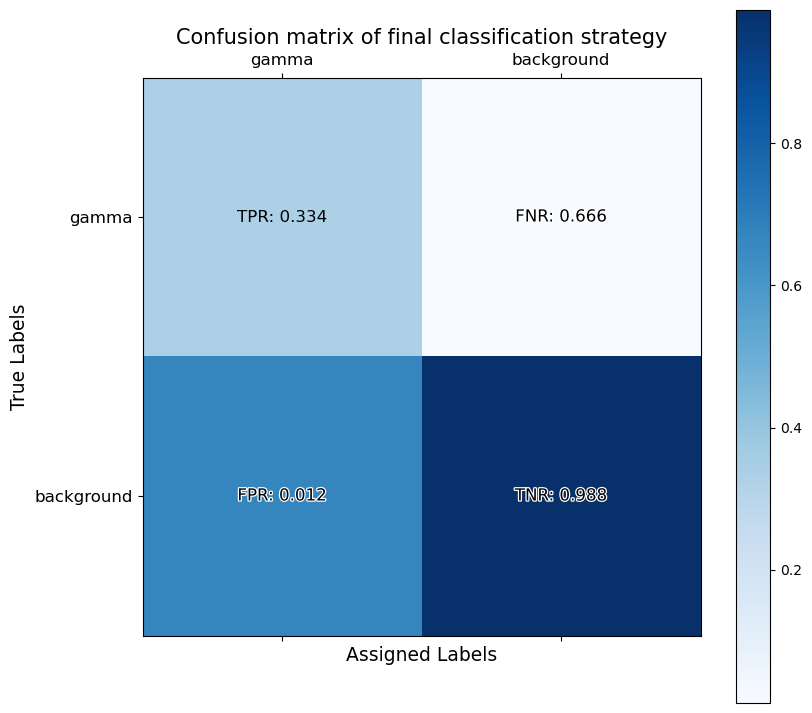

In [114]:

tpr = selected['true positives']/selected['total gammas']
tpr_avg = tpr.mean()

fpr = selected['false positives']/selected['total hadrons']
fpr_avg = fpr.mean()

tnr = selected['true negatives']/selected['total hadrons']
tnr_avg= tnr.mean()

fnr = selected['false negatives']/selected['total gammas']
fnr_avg= fnr.mean()

confusion_matrix = np.array([[tpr_avg, fpr_avg], [fnr_avg, tnr_avg]])

fig, ax = plt.subplots(figsize=(9, 9))
cax = ax.matshow(confusion_matrix, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_xticklabels(['gamma', 'background'],fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['gamma', 'background'],fontsize=12)

path_effects_white = [path_effects.withStroke(linewidth=1.8, foreground='white')]

# Adding text with white contour
text_params = {'ha': 'center', 'va': 'center', 'color': 'black', 'fontsize': 12, 'path_effects': path_effects_white}


ax.text(0, 0, f'TPR: {tpr_avg:.3f}', ha='center', va='center', color='black',fontsize=12)
ax.text(1, 0, f'FNR: {fnr_avg:.3f}', **text_params)
ax.text(0, 1, f'FPR: {fpr_avg:.3f}', **text_params)
ax.text(1, 1, f'TNR: {tnr_avg:.3f}', **text_params)

fig.colorbar(cax)

ax.set_title('Confusion matrix of final classification strategy',fontsize=15)
ax.set_xlabel('Assigned Labels',fontsize=13.5)
ax.set_ylabel('True Labels',fontsize=13.5)

plt.show()

# Part 8: Calculation of the observation time

Assuming that the telescope has a collection area of 10^9 cm^2 and that we are observing gamma rays between 50 GeV and 50 TeV, to what observation time does this measurement corresponds? (assume here the Crab spectrum measured by HEGRA [Aharonian, F. et al. 2000])

------da rivedere descrizione-------
- da capire +- 0.5
- da capire se vogliamo dividere il range 0.05 Tev - 50 Tev in due e usare il primo integrale per 1-50 e il secondo (log) per 0.05-1 (al momento non sono divisi)

To calculate the observation time corresponding to the Cherenkov telescope measurement, we use the Crab Nebula spectrum measured by HEGRA. Then, converting the telescope's collection area to square meters ( $A = 10^9 \, \text{cm}^2 = 10^5 \, \text{m}^2 $), we can determine
the event rate by integrating the flux over the energy range from **50 GeV to 50 TeV**:

$$
R = A \cdot J_{\gamma} =  A \int_{0.05 \, TeV}^{50 \, TeV} \frac{dJ_{\gamma}}{dE} dE
$$

This integration provides the **event rate in photons per second**. Given the total number of recorded events $n_\gamma$, we can then calculate the **observation time** by dividing the number of events by the event rate:

$$
\Delta t = \frac{n_{\gamma}}{R}
$$

In [115]:
# Constants
A = 10**9 * 1e-4  # collection area in m^2
E0 = 1.0  # TeV
Emin = 0.05  # TeV = 50 GeV
Emax = 50  # TeV
n_gamma, sigma_n_gamma = 4000, 200 #--------------------------------------insert our value here---------------------------

# Constants for the first integral
alpha1, alpha1_err = 2.59, 0.03
c1, c1_err = 2.79e-7, 0.02e-7

# Constants for the second integral
c2, c2_err = 2.67e-7, 0.01e-7
alpha2, alpha2_err = 2.47, 0.1
beta, beta_err = 0.11, 0.1

Primo integrale con errore dato da derivate parziali

# First integral
According to the study by **Aharonian et al. (2000)**, the differential flux of gamma rays in the range of $1-20 \, \text{TeV}$ is given by:

$$
\frac{dJ_{\gamma}}{dE} = (2.79 \pm 0.02) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.59 \pm 0.03)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_1 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_1} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_1 = (2.79 \pm 0.02) \times 10^{-7}, E_0 = 1 \, \text{TeV}, \alpha_1 = 2.59 \pm 0.03
$$
so the integral will be:
$$
J_\gamma = \frac{E_0^{\alpha_1} \cdot c_1}{-\alpha_1 + 1} \cdot \left( E_{\text{max}}^{-\alpha_1 + 1} - E_{\text{min}}^{-\alpha_1 + 1} \right)
$$
with $E_{\text{min}} = 0.05 \, \text{TeV}, E_{\text{max}} = 50 \, \text{TeV} $

### Error Propagation

We have uncertainties in the following parameters:

$$
c_1 = (2.79 \pm 0.02) \times 10^{-7}
$$
$$
\alpha_1 = 2.59 \pm 0.03
$$

Using the general error propagation formula the total uncertainty in R:

$$
\sigma_R = \sqrt{ \left( \frac{\partial R}{\partial c_1} \sigma_{c_1} \right)^2 + \left( \frac{\partial R}{\partial \alpha_1} \sigma_{\alpha_1} \right)^2 }
$$

The error for the time will be:
$$
\sigma_t = t \sqrt{ \left( \frac{\sigma_{n_{\gamma}}}{n_{\gamma}} \right)^2 + \left( \frac{\sigma_R}{R} \right)^2 }
$$

In [116]:
import sympy as sp

def uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err):
    #definisco i simboli
    c1_sym, alpha1_sym, Emin_sym, Emax_sym, E0_sym, A_sym = sp.symbols('c1 alpha1 Emin Emax E0 A')
    
    #definizione di R 
    R = (A_sym * c1_sym * (E0_sym**alpha1_sym) / (-alpha1_sym + 1)) * (Emax_sym**(-alpha1_sym + 1) - Emin_sym**(-alpha1_sym + 1))

    #calcolo le derivate parziali rispetto a c1 e alpha1
    dR_dc1 = sp.diff(R, c1_sym)
    dR_dalpha1 = sp.diff(R, alpha1_sym)
    
    #conversione a funzioni
    dR_dc1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dc1, 'numpy')
    dR_dalpha1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dalpha1, 'numpy')
    
    #calcolo il valore delle derivate e di R
    dR_dc1_val = dR_dc1_func(A, E0, Emin, Emax, c1, alpha1)
    dR_dalpha1_val = dR_dalpha1_func(A, E0, Emin, Emax, c1, alpha1)
    R_val = (A * c1 * (E0**alpha1) / (-alpha1 + 1)) * (Emax**(-alpha1 + 1) - Emin**(-alpha1 + 1))
    
    #incertezza totale su R
    sigma_R = np.sqrt((dR_dc1_val * c1_err) ** 2 + (dR_dalpha1_val * alpha1_err) ** 2)
    
    return R_val, sigma_R


#valore dell'errore su R
R_val, sigma_R = uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err)

t1 = (n_gamma / R_val) / 60
sigma_t1 = t1 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R_val)**2)) / 60

print(f"t1 = {t1:.2f} ± {sigma_t1:.2f} minutes")

t1 = 32.44 ± 0.05 minutes


## Second integral
At low energies there is a slight flattening of the spectrum. A fit with a logarithmic steepening of the power law spectrum gives (according to the study by **Aharonian et al. (2000)**):
$$
\frac{dJ_{\gamma}}{dE} = (2.67 \pm 0.01) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.47 \pm 0.1) -(0.11 \pm 0.1) \, \log(E)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_2 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_2 - \beta \, \log(E)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_2 = (2.67 \pm 0.01) \times 10^{-7}, E_0 = 1 \, \text{TeV}, \alpha_2 = 2.47 \pm 0.1, \beta = 0.11 \pm 0.1
$$
Because of the logarithmic correction, it's impossible to integrate it analytically in a straightforward way. Hence, to calculate this integral, we use two numerical integration methods: Romberg integration and Simpson's Rule.

###  Romberg integration
usando romb - da capire
#### using .quad

In [117]:
from scipy.integrate import quad

#definisco l'integranda
def dJ_gamma(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 - beta * np.log(E))

#definisco R
def R(c2, alpha2, beta):
    integral, _ = quad(dJ_gamma, Emin, Emax, args=(c2, alpha2, beta))
    return A * integral

#Monte Carlo for the error
N = 10000
c2_mc = np.random.normal(c2, c2_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta_mc = np.random.normal(beta, beta_err, N)

R_mc = np.array([R(c2, alpha2, beta) for c2, alpha2, beta in zip(c2_mc, alpha2_mc, beta_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2)) / 60

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 67.74 +- 0.75 minutes


### Simpson's Rule

The trapezoidal rule estimates the area under a curve by approximating the curve with straight-line segments. We can often get a
better result if we approximate the function instead with curves of some kind, Simpson’s rule does exactly this, using quadratic curves.

In [118]:
import numpy as np
from scipy.integrate import simpson

n = int(10e5)
E_values = np.linspace(Emin, Emax, n)

def dJ_gamma2(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 - beta * np.log(E))

J_gamma_values = dJ_gamma2(E_values, c2, alpha2, beta)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_dc2 = J_gamma / c2
    dJ_dalpha2 = -J_gamma * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2, E_values)
    dJ_dbeta = -J_gamma * np.log(E_values/E0) * np.log(E_values)
    dJ_dbeta = simpson(dJ_dbeta, E_values)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = sigma_J

t2_s = (n_gamma / R)/60
sigma_t2_s = t2_s * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2)) / 60

print(f"t2 = {t2_s:.2f} +- {sigma_t2_s:.2f} minutes")

t2 = 82.09 +- 0.07 minutes
